<a href="https://colab.research.google.com/github/Balogunhabeeb14/AirPollution-Prediction-Using-AI-and-IoT/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from pandas import DataFrame,Series
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score
import matplotlib
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
import missingno as msno # plotting missing data
import seaborn as sns # plotting library
from sklearn import svm
import xgboost as xg 

In [ ]:
'''
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin


class LSSVMRegression(BaseEstimator, RegressorMixin):
    """
    An Least Squared Support Vector Machine (LS-SVM) regression class, build 
    on the BaseEstimator and RegressorMixin base classes of sklearn. 
    (Let's hope furture upgrades of python sk-learn just doesn't break this...
    consider this a python feature)
    
    Attributes:
        - gamma : the hyper-parameter (float)
        - kernel: the kernel used     (string)
        - kernel_: the actual kernel function
        - x : the data on which the LSSVM is trained (call it support vectors)
        - y : the targets for the training data
        - coef_ : coefficents of the support vectors
        - intercept_ : intercept term+
        
    """
    def __init__(self, gamma:float=1.0, kernel:str=None, c:float=1.0, 
                 d:float=2, sigma:float=1.0):
        """
        Create a new regressor
        
        Parameters:
            - gamma: floating point value for the hyper-parameter gamma, DEFAULT=1.0
            - kernel: string indicating the kernel: {'linear','poly','rbf'}, DEFAULT='rbf'
            - the kernel parameters
                    * linear: none
                    * poly:
                        + c: scaling constant, DEFAULT=1.0
                        + d: polynomial power, DEFAULT=2
                    * rbf:
                        + sigma: scaling constant, DEFAULT=1.0
        """
        self.gamma=gamma
        self.c=c
        self.d=d
        self.sigma=sigma
        if (kernel is None):
            self.kernel='rbf'
        else:
            self.kernel=kernel
        
        params=dict()
        if (kernel=='poly'):
            params['c']=c
            params['d']=d
        elif (kernel=='rbf'):
            params['sigma']=sigma
            
        self.kernel_=LSSVMRegression.__set_kernel(self.kernel,**params)
        
        #model parameters
        self.x=None
        self.y=None
        self.coef_=None
        self.intercept_=None
        
    def get_params(self, deep=True):
        """
            The get_params functionality provides the parameters of the LSSVMRegression class.
            These exclude the modelparameters.
        """
        return {"c": self.c, "d": self.d, "gamma": self.gamma, "kernel": self.kernel, "sigma":self.sigma}

    def set_params(self, **parameters):
        """
            Set the parameters of the class. Important note: This should do anything that is
            done to relevant parameters in __init__ as sklearn's GridSearchCV uses this instead of init.
            More info:  https://scikit-learn.org/stable/developers/develop.html
        """
        #print("SETTING PARAMETERS IN LSSVM:",parameters.items())
        
        for parameter, value in parameters.items():
            #setattr should do the trick for gamma,c,d,sigma and kernel
            setattr(self, parameter, value)
        #now also update the actual kernel
        params=dict()
        if (self.kernel=='poly'):
            params['c']=self.c
            params['d']=self.d
        elif (self.kernel=='rbf'):
            params['sigma']=self.sigma
        self.kernel_=LSSVMRegression.__set_kernel(self.kernel,**params)
        
        return self
    
    def set_attributes(self, **parameters):
        """
            Manually set the attributes of the model. This should generally not be done, except when
            testing some specific behaviour, or creating an averaged model.
            
            Parameters are provided as a dictionary.
                - 'intercept_' : float intercept
                - 'coef_'      : float array of coefficients
                - 'support_'   : array of support vectors, in the same order sorted as the coefficients
        """
        #not the most efficient way of doing it...but sufficient for the time being    
        for param, value in parameters.items():
            if (param == 'intercept_'):
                self.intercept_=value
            elif (param == 'coef_'):
                self.coef_=value
            elif (param == 'support_'):
                self.x=value

    @staticmethod
    def __set_kernel(name:str, **params):
        """
            Internal static function to set the kernel function.
            NOTE: The second "vector" xj will be the one which generally 
                  contains an array of possible vectors, while xi should be a single 
                  vector. Therefore, the numpy dot-product requires xj to
                  be transposed.
            
            The kernel returns either a scalar or a numpy nd-array of 
            rank 1 (i.e. a vector), if it returns something else the result 
            is wrong if xi is an array.
            
        """
        def linear(xi,xj):
            """
               v*v=scal (dot-product OK)
               v*m=v    (dot-product OK)
               m*m=m    (matmul for 2Dx2D, ok with dot-product)
            """
            return np.dot(xi,xj.T)
        
        def poly(xi,xj,c=params.get('c',1.0),d=params.get('d',2)):
            """
                Polynomial kernel ={1+ (xi*xj^T)/c }^d
                
                Parameters:
                    - c: scaling constant, DEFAULT=1.0
                    - d: polynomial power, DEFAULT=2
                    - xi and xj are numpy nd-arrays
                (cf: https://en.wikipedia.org/wiki/Least-squares_support-vector_machine )
                
                works on same as linear
            """
            return ((np.dot(xi,xj.T))/c  + 1 )**d
        
        def rbf(xi,xj,sigma=params.get('sigma',1.0)):
            """
            Radial Basis Function kernel= exp(- ||xj-xi||² / (2*sigma²))
            In this formulation, the rbf is also known as the Gaussian kernel of variance sigma²
            As the Euclidean distance is strict positive, the results of this kernel
            are in the range [0..1] (x € [+infty..0])
            
            Parameters:
                - sigma: scaling constant, DEFAULT=1.0
                - xi and xj are numpy nd-arrays
            (cf: https://en.wikipedia.org/wiki/Least-squares_support-vector_machine )
            
            Possible combinations of xi and xj:
                vect & vect   -> scalar
                vect & array  -> vect
                array & array -> array => this one requires a pair distance...which can not be done with matmul and dot
                
                The vectors are the rows of the arrays (Arr[0,:]=first vect)
                
                The squared distance between vectors= sqr(sqrt( sum_i(vi-wi)² ))
                --> sqr & sqrt cancel
                --> you could use a dot-product operator for vectors...but this 
                seems to fail for nd-arrays.
                
            For vectors:
                ||x-y||²=sum_i(x_i-y_i)²=sum_i(x²_i+y²_i-2x_iy_i)
                --> all products between vectors can be done via np.dot: takes the squares & sum
            
            For vector x and array of vectors y:
                --> x²_i : these are vectors: dot gives a scalar
                --> y²_i : this should be a list of scalars, one per vector. 
                            => np.dot gives a 2d array
                            => so   1) square manually (squares each element)
                                    2) sum over every row (axis=1...but only in case we have a 2D array)
                --> x_iy_i : this should also be a list of scalars. np.dot does the trick, 
                            and even gives the same result if matrix and vector are exchanged
            
            for array of vectors x and array of vectors y:
                --> either loop over vectors of x, and for each do the above
                --> or use cdist which calculates the pairwise distance and use that in the exp
                
            """
            from scipy.spatial.distance import cdist
            
#            print('LS_SVM DEBUG: Sigma=',sigma,'  type=',type(sigma) )
#            print('              xi   =',xi,'  type=',type(xi))
#            print('              xj   =',xj,'  type=',type(xj))
#            
            
            if (xi.ndim==2 and xi.ndim==xj.ndim): # both are 2D matrices
                return np.exp(-(cdist(xi,xj,metric='sqeuclidean'))/(2*(sigma**2)) )
            elif ((xi.ndim<2) and (xj.ndim<3)):
                ax=len(xj.shape)-1 #compensate for python zero-base
                return np.exp(-(np.dot(xi,xi) + (xj**2).sum(axis=ax) - 2*np.dot(xi,xj.T) )/(2*(sigma**2)))
            else:
                message="The rbf kernel is not suited for arrays with rank >2"
                raise Exception(message)
        
        kernels={'linear': linear, 'poly': poly, 'rbf': rbf}
        if kernels.get(name) is not None:
            return kernels[name]
        else: #unknown kernel: crash and burn?
            message="Kernel "+name+" is not implemented. Please choose from : "+str(list(kernels.keys())).strip('[]')
            raise KeyError(message)
        
    def __OptimizeParams(self):
        """
        Solve the matrix operation to get the coefficients.
        --> equation 3.5 and 3.6 of the book by Suykens
        ==> that is for classification, for regression slightly different cf Dilmen paper 2017
        
        self.y: 1D array
        self.X: 2D array (with rows the vectors: X[0,:] first vector)
        
        Set the class parameters:
            - self.intercept_ : intercept
            - self.coef_      : coefficients
        
        
        """
              
        #Regression
        Omega=self.kernel_(self.x,self.x)
        Ones=np.array([[1]]*len(self.y)) # needs to be a 2D 1-column vector, hence [[ ]]
        
        A_dag = np.linalg.pinv(np.block([
            [0,                           Ones.T                      ],
            [Ones,   Omega + self.gamma**-1 * np.identity(len(self.y))]
        ])) #need to check if the matrix is OK--> y.T parts
        B = np.concatenate((np.array([0]),self.y), axis=None)
        
        solution = np.dot(A_dag, B)
        self.intercept_ = solution[0]
        self.coef_      = solution[1:]
        
    
    def fit(self,X:np.ndarray,y:np.ndarray):
        """
        Fit the parameters based on the support vectors X (and store these as they are
        parameters of the LS-SVM as well, because needed for prediction)
        
        We are doing Regression.
        Parameters:
            - X : 2D array of vectors (1 per row: X[0,:] first vector)
            - y : 1D vector of targets
        """
        
        #print("IN FIT==> GAMMA=",self.gamma,"  SIGMA=",self.sigma)
        
        if isinstance(X,pd.DataFrame) or isinstance(X,pd.Series):
            Xloc=X.to_numpy()
        else:
            Xloc=X
        
        if isinstance(y,pd.DataFrame) or isinstance(y,pd.Series):
            yloc=y.to_numpy()
        else:
            yloc=y
        
        #check the dimensionality of the input
        if (Xloc.ndim==2) and (yloc.ndim==1):
            self.x = Xloc
            self.y = yloc
            self.__OptimizeParams()
        else:
            message="The fit procedure requires a 2D numpy array of features and 1D array of targets"
            raise Exception(message)
        
    def predict(self,X:np.ndarray)->np.ndarray:
        """
        Predict the regression values for a set of feature vectors
        
        Parameters:
            - X: ndarray of feature vectors (max: 2D), 1 per row if more than one.
        
        """
        Ker = self.kernel_(X,self.x) #second component should be the array of training vectors
        Y=np.dot(self.coef_,Ker.T) +self.intercept_
            
        return Y

In [ ]:
from google.colab import files

uploaded = files.upload()

MessageError: ignored

In [ ]:
import pandas as pd

#import the data
df=pd.read_csv('fulldataset-pollutant-traffic-location-140820.csv')

In [ ]:
len(df)

34374

In [ ]:
# get rid of the unwanted index column
df.drop('Unnamed: 0', axis=1, inplace=True)#
dff=df.copy()
df.head(10)

,Ambient pressure,Humidity,NO,NO2,O3,Temp,PM1,PM10,PM25,Holiday,road_type,all_motor_vehicles,weekday,Timestamp-UTC,x,y,z
0,100951,91,13,27,29,6,10,28,17,0,1,42,4,1576879200,0.364225,0.575243,0.732418
1,103081,91,10,16,25,5,8,23,15,0,1,42,4,1576879200,0.356339,0.576607,0.735219
2,97777,91,20,31,17,6,9,24,16,0,1,42,4,1576879200,0.361029,0.580891,0.729536
3,101499,93,19,20,24,5,9,27,18,0,1,42,4,1576879200,0.363182,0.574933,0.733178
4,97855,91,0,1,40,5,9,26,18,0,1,42,4,1576879200,0.361706,0.579371,0.730409
5,97788,93,27,35,26,5,10,29,18,0,1,42,4,1576879200,0.357596,0.581629,0.730639
6,100371,91,17,22,32,5,8,24,16,0,1,42,4,1576879200,0.382852,0.578252,0.720451
7,37854,94,10,43,29,5,10,28,19,0,1,42,4,1576879200,0.384391,0.573800,0.723186
8,99983,91,10,15,36,6,9,25,17,0,1,42,4,1576879200,0.377900,0.577356,0.723776
9,101240,89,4,30,26,6,10,29,20,0,1,42,4,1576879200,0.367102,0.573776,0.732132


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34374 entries, 0 to 34373
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Ambient pressure    34374 non-null  int64  
 1   Humidity            34374 non-null  int64  
 2   NO                  34374 non-null  int64  
 3   NO2                 34374 non-null  int64  
 4   O3                  34374 non-null  int64  
 5   Temp                34374 non-null  int64  
 6   PM1                 34374 non-null  int64  
 7   PM10                34374 non-null  int64  
 8   PM25                34374 non-null  int64  
 9   Holiday             34374 non-null  int64  
 10  road_type           34374 non-null  int64  
 11  all_motor_vehicles  34374 non-null  int64  
 12  weekday             34374 non-null  int64  
 13  Timestamp-UTC       34374 non-null  int64  
 14  x                   34374 non-null  float64
 15  y                   34374 non-null  float64
 16  z   

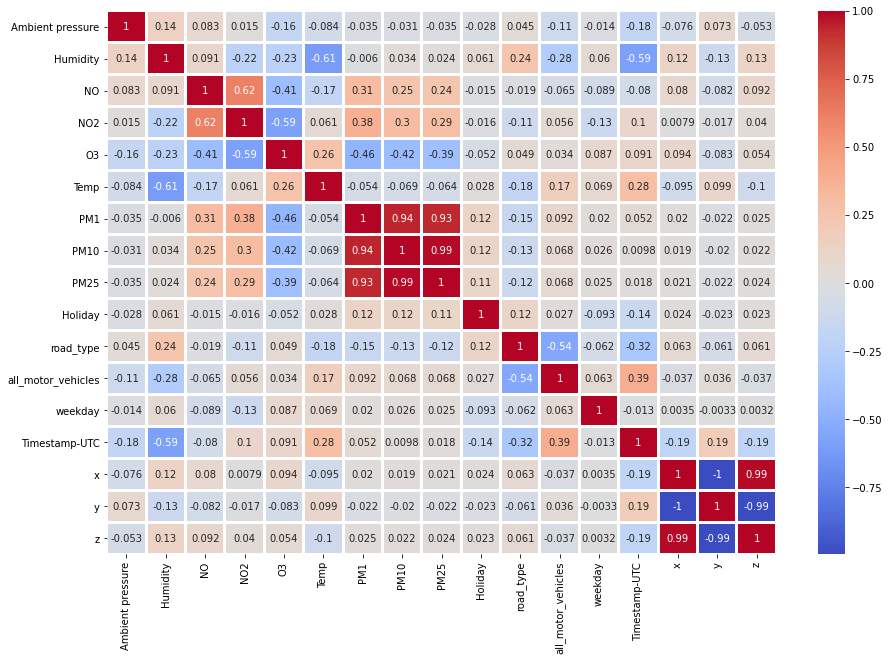

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.heatmap(df.corr(),cmap='coolwarm',ax=ax,annot=True,linewidths=2)

In [ ]:
df['road_type'].value_counts()

0    19216
1    15158
Name: road_type, dtype: int64

In [ ]:
df['weekday'].value_counts()

6    5046
0    4975
1    4947
2    4908
4    4860
3    4847
5    4791
Name: weekday, dtype: int64

Text(0, 0.5, 'road_type')

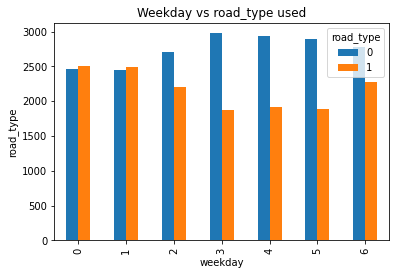

In [ ]:
pd.crosstab(df.weekday,df.road_type).plot(kind='bar')
plt.title('Weekday vs road_type used')
plt.xlabel('weekday')
plt.ylabel('road_type')

In [ ]:
#scatterplot
import seaborn as sns
sns.set()
sns.pairplot(df, size = 2.5)
plt.show();

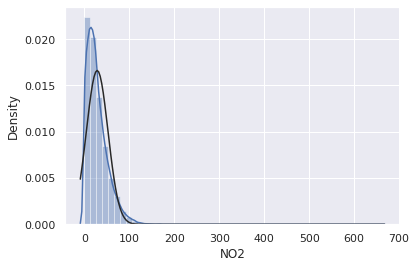

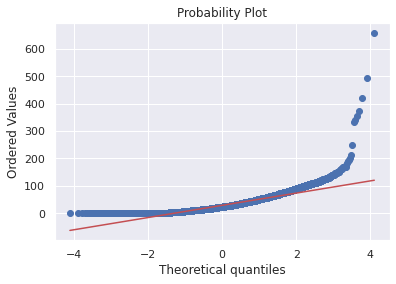

In [ ]:
#histogram and normal probability plot
sns.distplot(df['NO2'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['NO2'], plot=plt)

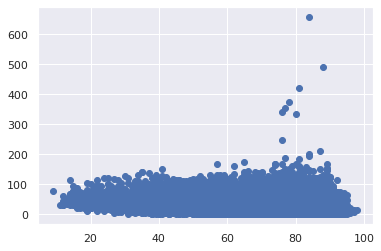

In [ ]:
#bivariate analysis 

#scatter plot
plt.scatter(df['Humidity'], df['NO2']);

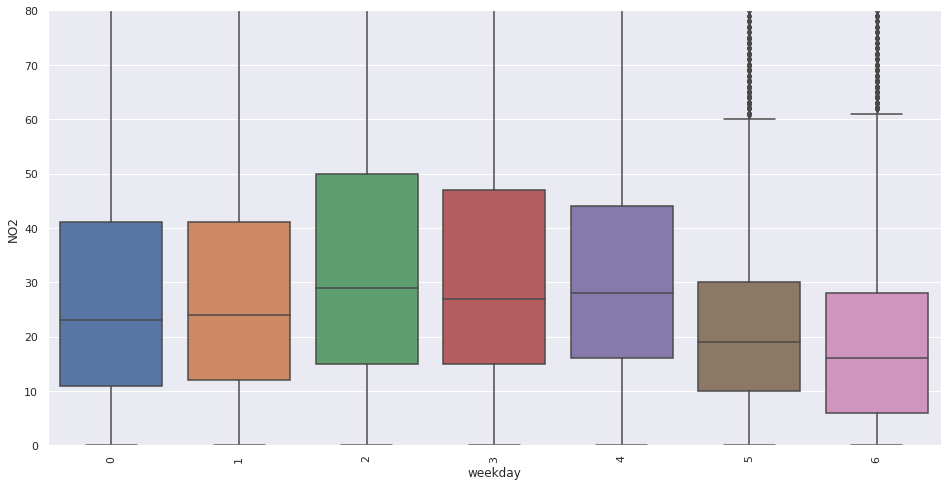

In [ ]:
var = 'weekday'
data = pd.concat([df['NO2'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="NO2", data=data)
fig.axis(ymin=0, ymax=80);
plt.xticks(rotation=90);

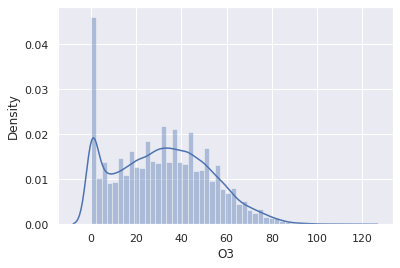

In [ ]:
sns.distplot(df['O3'])

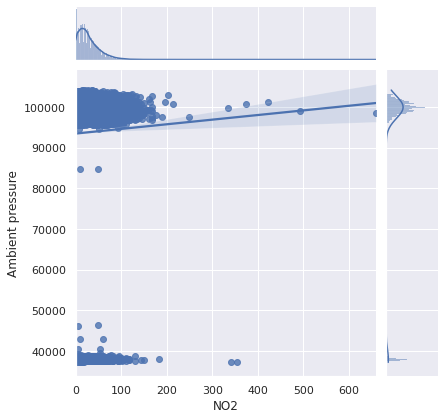

In [ ]:
sns.jointplot(df['NO2'], df['Ambient pressure'], kind='reg')

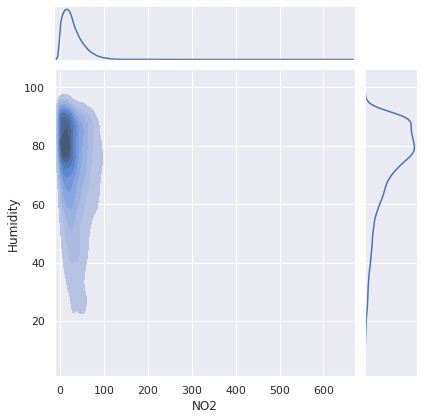

In [ ]:
sns.jointplot(df['NO2'], df['Humidity'], kind='kde', shade=True)

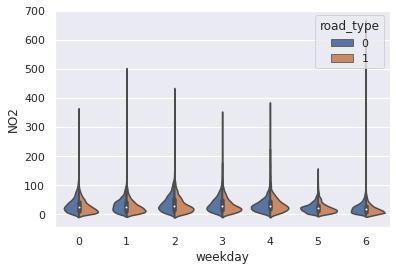

In [ ]:
sns.violinplot(x="weekday", y="NO2", hue="road_type", data=df, split=True);

In [ ]:
# convert the road type, weekday, and holiday to object type as they are categorical

#df[['road_type','weekday','Holiday']]=df[['road_type','weekday','Holiday']].to_string()
#print(df.dtypes)

Ambient pressure        int64
Humidity                int64
NO                      int64
NO2                     int64
O3                      int64
Temp                    int64
PM1                     int64
PM10                    int64
PM25                    int64
Holiday                object
road_type              object
all_motor_vehicles      int64
weekday                object
Timestamp-UTC           int64
x                     float64
y                     float64
z                     float64
dtype: object


In [ ]:
y = df.pop('NO2')
X = df.copy().values

In [ ]:
pip install Boruta

     |████████████████████████████████| 61kB 2.0MB/s 


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

rf = RandomForestClassifier(n_jobs=-1, class_weight=None, max_depth=7, random_state=0)
# Define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=0)

In [ ]:
feat_selector.fit(X, y)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	2
Iteration: 	9 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	2
Iteration: 	10 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	2
Iteration: 	11 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	2
Iteration: 	12 / 100
Confirmed: 	14
Tentative: 	0
Rejected: 	2


BorutaPy finished running.

Iteration: 	13 / 100
Confirmed: 	14
Tentative: 	0
Rejected: 	2


BorutaPy(alpha=0.05,
         estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                          class_weight=None, criterion='gini',
                                          max_depth=7, max_features='auto',
                                          max_leaf_nodes=None, max_samples=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=75, n_jobs=-1,
                                          oob_score=False,
                                          random_state=RandomState(MT19937) at 0x7F15412D2048,
                                          verbose=0, warm_start=False),
         max_iter=100, n_estimators='auto

In [ ]:
# Check selected features
print(feat_selector.support_)
# Select the chosen features from our dataframe.
selected = X[:, feat_selector.support_]
print ("")
print ("Selected Feature Matrix Shape")
print (selected.shape)

[ True  True  True  True  True  True  True  True False False  True  True
  True  True  True  True]

Selected Feature Matrix Shape
(34374, 14)


In [ ]:
feat_selector.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1])

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)

In [ ]:
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

NameError: ignored

In [ ]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=df.columns)
my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
feat_importances.nlargest(14).plot(kind='barh',color=my_colors)
plt.title('Important Features')
plt.xlabel('Feature Importance')
plt.show()

AttributeError: ignored

In [ ]:
# step forward feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
sfs = SFS(RandomForestRegressor(n_estimators=10, n_jobs=4, random_state=10), 
           k_features=14, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='r2',
           cv=2)

sfs = sfs.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   10.1s finished

[2020-10-09 09:00:33] Features: 1/14 -- score: 0.38104285824116346[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    8.4s finished

[2020-10-09 09:00:41] Features: 2/14 -- score: 0.41862874340840894[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:   11.1s finished

[2020-10-09 09:00:53] Features: 3/14 -- score: 0.5630988637901784[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done

In [ ]:
# indices of the selected columns
sfs.k_feature_idx_

(1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)

In [ ]:
sfs.k_feature_names_

('1', '2', '3', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15')

In [ ]:
# step backward feature selection algorithm

sfs = SFS(RandomForestRegressor(n_estimators=10, n_jobs=4, random_state=10), 
           k_features=14, 
           forward=False, 
           floating=False, 
           verbose=2,
           scoring='r2',
           cv=2)

sfs = sfs.fit(X,y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   36.1s finished

[2020-10-09 09:07:00] Features: 15/14 -- score: 0.6449949214313807[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   31.6s finished

[2020-10-09 09:07:32] Features: 14/14 -- score: 0.6494608360615434

In [ ]:
sfs.k_feature_idx_

(1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)

In [ ]:
#use the features selected and create a new dataframe to work with

df_new=dff[['weekday','PM25','PM10','Temp','Ambient pressure','Humidity','all_motor_vehicles','NO','Timestamp-UTC','O3','NO2']]
df_new.describe()



,weekday,PM25,PM10,Temp,Ambient pressure,Humidity,all_motor_vehicles,NO,Timestamp-UTC,O3,NO2
count,34374.000000,34374.000000,34374.000000,34374.000000,34374.000000,34374.000000,34374.000000,34374.000000,3.437400e+04,34374.000000,34374.000000
mean,2.995724,10.296707,17.770873,8.904375,93823.056933,73.389364,568.149212,15.734770,1.581762e+09,31.707221,28.656630
std,2.010275,10.024200,12.063037,3.909118,18502.855287,15.076769,826.970517,24.623655,2.874948e+06,20.922837,23.997692
min,0.000000,4.000000,10.000000,0.000000,37245.000000,9.000000,0.000000,0.000000,1.576836e+09,0.000000,0.000000
25%,1.000000,5.000000,11.000000,7.000000,98534.250000,66.000000,39.000000,4.000000,1.579295e+09,15.000000,11.000000
50%,3.000000,6.000000,13.000000,8.000000,99736.000000,77.000000,194.000000,8.000000,1.581714e+09,32.000000,23.000000
75%,5.000000,13.000000,20.000000,11.000000,100956.000000,84.000000,692.000000,18.000000,1.584180e+09,47.000000,40.000000
max,6.000000,917.000000,1107.000000,33.000000,104184.000000,98.000000,5319.000000,579.000000,1.588316e+09,119.000000,659.000000


In [ ]:
print(df_new.isnull().sum())

weekday               0
PM25                  0
PM10                  0
Temp                  0
Ambient pressure      0
Humidity              0
all_motor_vehicles    0
NO                    0
Timestamp-UTC         0
O3                    0
NO2                   0
dtype: int64


In [ ]:
#Split dataset into inputs and outputs
import numpy as np
from sklearn.model_selection import train_test_split
df=df_new
labels=df['NO2']
df=df.drop('NO2',axis=1)
df = df.values
labels = labels.values

X_train,X_test,y_train,y_test = train_test_split(df,labels,test_size = 0.4)

In [ ]:
#scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(32)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [ ]:
explained_variance=pca.explained_variance_ratio_

In [ ]:
print(explained_variance)

[0.26019153 0.21517487 0.11361467 0.09701149 0.09491256 0.08048781
 0.05812165 0.05292391 0.02659252 0.00096898]


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [ ]:
import time
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':['rbf','linear','poly'],
              'gamma':[0.0001,0.001, 0.01, 0.1, 1.0,10.0,100.0,1000.0],
             'sigma':[0.0001,0.001, 0.01, 0.1, 1.0,10.0,100.0,1000.0]}

lssvm = LSSVMRegression() 
grid = GridSearchCV(lssvm, parameters)
start_time = time.time()
grid_result = grid.fit(X_train,y_train)
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + 'ms')

In [ ]:
#df without PCA
df2=df.sample(frac=0.1,replace=True)

In [ ]:
import time
from sklearn.model_selection import RandomizedSearchCV
lssvm = LSSVMRegression()
random_grid = {'kernel':['rbf','linear','poly'],
              'gamma':[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10,100.0,1000.0],
              'sigma':[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10,100.0,1000.0]}
lssvm_random = RandomizedSearchCV(estimator = lssvm, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model

start_time = time.time()
grid_result = lssvm_random.fit(X_train,y_train)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + 'ms')

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.9min finished


Best: 0.743680 using {'sigma': 10, 'kernel': 'rbf', 'gamma': 1000.0}
Execution time: 601.9570069313049ms


In [ ]:
from sklearn import metrics
from pandas import DataFrame,Series
from sklearn.metrics import explained_variance_score


lssvm = LSSVMRegression(kernel='rbf',gamma=1000.0,sigma=10.0) 

lssvm.fit(X_train,y_train)
#Prediction using test set 
y_pred = lssvm.predict(X_test)
mae=metrics.mean_absolute_error(y_test, y_pred)
mse=metrics.mean_squared_error(y_test, y_pred)
# Printing the metrics
print('R2 square:',metrics.r2_score(y_test, y_pred))
print('MAE: ', mae)
print('MSE: ', mse)
print('EVS:', explained_variance_score(y_test, y_pred))

R2 square: 0.7359202408673686
MAE:  8.841891638394841
MSE:  137.97148005003731
EVS: 0.7360518084549781


In [ ]:
pred = pd.DataFrame(y_pred, columns = ['predicted'])
Actual=pd.DataFrame(y_test, columns=['Test Set'])

In [ ]:
compare=Actual.join(pred)
compare

,Test Set,predicted
0,46,24.506569
1,68,57.003130
2,16,16.437472
3,0,5.734232
4,71,79.168947


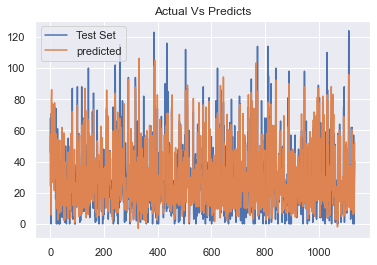

In [ ]:
#plt.ylim([80000,85000])
compare.plot(title="Actual Vs Predicts")

In [ ]:
for i in y_pred:
    for j in y_test:
        print (i,j)   

24.506569057253046 46
24.506569057253046 68
24.506569057253046 16
24.506569057253046 0
24.506569057253046 71
24.506569057253046 51
24.506569057253046 29
24.506569057253046 33
24.506569057253046 37
24.506569057253046 66
24.506569057253046 27
24.506569057253046 39
24.506569057253046 52
24.506569057253046 26
24.506569057253046 29
24.506569057253046 46
24.506569057253046 75
24.506569057253046 38
24.506569057253046 52
24.506569057253046 71
24.506569057253046 16
24.506569057253046 40
24.506569057253046 74
24.506569057253046 0
24.506569057253046 54
24.506569057253046 17
24.506569057253046 18
24.506569057253046 61
24.506569057253046 0
24.506569057253046 12
24.506569057253046 23
24.506569057253046 46
24.506569057253046 46
24.506569057253046 44
24.506569057253046 0
24.506569057253046 41
24.506569057253046 0
24.506569057253046 21
24.506569057253046 14
24.506569057253046 27
24.506569057253046 5
24.506569057253046 5
24.506569057253046 8
24.506569057253046 37
24.506569057253046 31
24.506569057253046

24.506569057253046 22
24.506569057253046 17
24.506569057253046 24
24.506569057253046 23
24.506569057253046 5
24.506569057253046 0
24.506569057253046 68
24.506569057253046 13
24.506569057253046 49
24.506569057253046 19
24.506569057253046 0
24.506569057253046 15
24.506569057253046 18
24.506569057253046 31
24.506569057253046 18
24.506569057253046 88
24.506569057253046 40
24.506569057253046 29
24.506569057253046 20
24.506569057253046 50
24.506569057253046 114
24.506569057253046 6
24.506569057253046 36
24.506569057253046 14
24.506569057253046 32
24.506569057253046 23
24.506569057253046 3
24.506569057253046 5
24.506569057253046 41
24.506569057253046 42
24.506569057253046 22
24.506569057253046 23
24.506569057253046 13
24.506569057253046 7
24.506569057253046 22
24.506569057253046 79
24.506569057253046 49
24.506569057253046 40
24.506569057253046 46
24.506569057253046 54
24.506569057253046 0
24.506569057253046 40
24.506569057253046 17
24.506569057253046 17
24.506569057253046 12
24.50656905725304

57.00312973510995 35
57.00312973510995 42
57.00312973510995 7
57.00312973510995 28
57.00312973510995 20
57.00312973510995 14
57.00312973510995 5
57.00312973510995 5
57.00312973510995 12
57.00312973510995 16
57.00312973510995 37
57.00312973510995 75
57.00312973510995 0
57.00312973510995 2
57.00312973510995 39
57.00312973510995 2
57.00312973510995 29
57.00312973510995 32
57.00312973510995 16
57.00312973510995 102
57.00312973510995 58
57.00312973510995 10
57.00312973510995 46
57.00312973510995 8
57.00312973510995 53
57.00312973510995 31
57.00312973510995 66
57.00312973510995 5
57.00312973510995 61
57.00312973510995 9
57.00312973510995 0
57.00312973510995 25
57.00312973510995 10
57.00312973510995 41
57.00312973510995 26
57.00312973510995 54
57.00312973510995 115
57.00312973510995 81
57.00312973510995 14
57.00312973510995 37
57.00312973510995 69
57.00312973510995 30
57.00312973510995 31
57.00312973510995 48
57.00312973510995 40
57.00312973510995 20
57.00312973510995 79
57.00312973510995 51


57.00312973510995 21
57.00312973510995 20
57.00312973510995 17
57.00312973510995 11
57.00312973510995 31
57.00312973510995 41
57.00312973510995 1
57.00312973510995 28
57.00312973510995 62
57.00312973510995 12
57.00312973510995 10
57.00312973510995 70
57.00312973510995 28
57.00312973510995 9
57.00312973510995 19
57.00312973510995 11
57.00312973510995 66
57.00312973510995 5
57.00312973510995 56
57.00312973510995 60
57.00312973510995 3
57.00312973510995 24
57.00312973510995 14
57.00312973510995 66
57.00312973510995 18
57.00312973510995 74
57.00312973510995 27
57.00312973510995 89
57.00312973510995 21
57.00312973510995 33
57.00312973510995 76
57.00312973510995 81
57.00312973510995 15
57.00312973510995 4
57.00312973510995 39
57.00312973510995 65
57.00312973510995 4
57.00312973510995 40
57.00312973510995 27
57.00312973510995 10
57.00312973510995 39
57.00312973510995 29
57.00312973510995 15
57.00312973510995 78
57.00312973510995 2
57.00312973510995 48
57.00312973510995 44
57.00312973510995 19

16.437472098537228 16
16.437472098537228 9
16.437472098537228 26
16.437472098537228 82
16.437472098537228 34
16.437472098537228 11
16.437472098537228 57
16.437472098537228 31
16.437472098537228 18
16.437472098537228 9
16.437472098537228 22
16.437472098537228 26
16.437472098537228 4
16.437472098537228 0
16.437472098537228 34
16.437472098537228 59
16.437472098537228 24
16.437472098537228 27
16.437472098537228 26
16.437472098537228 1
16.437472098537228 16
16.437472098537228 16
16.437472098537228 23
16.437472098537228 20
16.437472098537228 14
16.437472098537228 55
16.437472098537228 28
16.437472098537228 44
16.437472098537228 13
16.437472098537228 63
16.437472098537228 9
16.437472098537228 21
16.437472098537228 18
16.437472098537228 39
16.437472098537228 17
16.437472098537228 59
16.437472098537228 0
16.437472098537228 14
16.437472098537228 7
16.437472098537228 23
16.437472098537228 11
16.437472098537228 123
16.437472098537228 13
16.437472098537228 22
16.437472098537228 76
16.43747209853722

16.437472098537228 2
16.437472098537228 27
16.437472098537228 20
16.437472098537228 32
16.437472098537228 30
16.437472098537228 12
16.437472098537228 81
16.437472098537228 15
16.437472098537228 14
16.437472098537228 98
16.437472098537228 0
16.437472098537228 28
16.437472098537228 41
16.437472098537228 37
16.437472098537228 0
16.437472098537228 2
16.437472098537228 57
16.437472098537228 42
16.437472098537228 0
16.437472098537228 24
16.437472098537228 41
16.437472098537228 10
16.437472098537228 33
16.437472098537228 27
16.437472098537228 39
16.437472098537228 12
16.437472098537228 36
16.437472098537228 21
16.437472098537228 25
16.437472098537228 24
16.437472098537228 33
16.437472098537228 13
16.437472098537228 57
16.437472098537228 8
16.437472098537228 12
16.437472098537228 32
16.437472098537228 9
16.437472098537228 18
16.437472098537228 4
16.437472098537228 16
16.437472098537228 5
16.437472098537228 20
16.437472098537228 24
16.437472098537228 21
16.437472098537228 16
16.437472098537228 

5.734231997442521 13
5.734231997442521 4
5.734231997442521 4
5.734231997442521 13
5.734231997442521 10
5.734231997442521 28
5.734231997442521 27
5.734231997442521 31
5.734231997442521 90
5.734231997442521 40
5.734231997442521 48
5.734231997442521 25
5.734231997442521 15
5.734231997442521 8
5.734231997442521 116
5.734231997442521 35
5.734231997442521 24
5.734231997442521 10
5.734231997442521 85
5.734231997442521 16
5.734231997442521 23
5.734231997442521 52
5.734231997442521 26
5.734231997442521 52
5.734231997442521 29
5.734231997442521 40
5.734231997442521 8
5.734231997442521 13
5.734231997442521 30
5.734231997442521 21
5.734231997442521 11
5.734231997442521 5
5.734231997442521 72
5.734231997442521 57
5.734231997442521 72
5.734231997442521 7
5.734231997442521 13
5.734231997442521 28
5.734231997442521 9
5.734231997442521 25
5.734231997442521 10
5.734231997442521 6
5.734231997442521 9
5.734231997442521 0
5.734231997442521 10
5.734231997442521 24
5.734231997442521 2
5.734231997442521 36
5.

5.734231997442521 17
5.734231997442521 62
5.734231997442521 15
5.734231997442521 10
5.734231997442521 12
5.734231997442521 0
5.734231997442521 25
5.734231997442521 57
5.734231997442521 23
5.734231997442521 0
5.734231997442521 27
5.734231997442521 40
79.16894717802757 46
79.16894717802757 68
79.16894717802757 16
79.16894717802757 0
79.16894717802757 71
79.16894717802757 51
79.16894717802757 29
79.16894717802757 33
79.16894717802757 37
79.16894717802757 66
79.16894717802757 27
79.16894717802757 39
79.16894717802757 52
79.16894717802757 26
79.16894717802757 29
79.16894717802757 46
79.16894717802757 75
79.16894717802757 38
79.16894717802757 52
79.16894717802757 71
79.16894717802757 16
79.16894717802757 40
79.16894717802757 74
79.16894717802757 0
79.16894717802757 54
79.16894717802757 17
79.16894717802757 18
79.16894717802757 61
79.16894717802757 0
79.16894717802757 12
79.16894717802757 23
79.16894717802757 46
79.16894717802757 46
79.16894717802757 44
79.16894717802757 0
79.16894717802757 4

79.16894717802757 0
79.16894717802757 33
79.16894717802757 6
79.16894717802757 26
79.16894717802757 24
79.16894717802757 41
79.16894717802757 49
79.16894717802757 2
79.16894717802757 41
79.16894717802757 8
79.16894717802757 18
79.16894717802757 9
79.16894717802757 23
79.16894717802757 18
79.16894717802757 28
79.16894717802757 28
79.16894717802757 79
79.16894717802757 52
79.16894717802757 69
79.16894717802757 16
79.16894717802757 15
79.16894717802757 22
79.16894717802757 100
79.16894717802757 10
79.16894717802757 12
79.16894717802757 33
79.16894717802757 46
79.16894717802757 38
79.16894717802757 22
79.16894717802757 50
79.16894717802757 16
79.16894717802757 64
79.16894717802757 4
79.16894717802757 62
79.16894717802757 86
79.16894717802757 7
79.16894717802757 8
79.16894717802757 25
79.16894717802757 18
79.16894717802757 13
79.16894717802757 20
79.16894717802757 12
79.16894717802757 32
79.16894717802757 19
79.16894717802757 78
79.16894717802757 33
79.16894717802757 5
79.16894717802757 63


86.1120866993308 10
86.1120866993308 0
86.1120866993308 15
86.1120866993308 21
86.1120866993308 28
86.1120866993308 24
86.1120866993308 40
86.1120866993308 56
86.1120866993308 18
86.1120866993308 29
86.1120866993308 8
86.1120866993308 31
86.1120866993308 9
86.1120866993308 32
86.1120866993308 0
86.1120866993308 14
86.1120866993308 12
86.1120866993308 3
86.1120866993308 48
86.1120866993308 6
86.1120866993308 15
86.1120866993308 37
86.1120866993308 25
86.1120866993308 25
86.1120866993308 26
86.1120866993308 16
86.1120866993308 12
86.1120866993308 42
86.1120866993308 74
86.1120866993308 74
86.1120866993308 18
86.1120866993308 12
86.1120866993308 22
86.1120866993308 69
86.1120866993308 48
86.1120866993308 3
86.1120866993308 9
86.1120866993308 26
86.1120866993308 25
86.1120866993308 46
86.1120866993308 17
86.1120866993308 47
86.1120866993308 35
86.1120866993308 42
86.1120866993308 7
86.1120866993308 28
86.1120866993308 20
86.1120866993308 14
86.1120866993308 5
86.1120866993308 5
86.11208669

86.1120866993308 23
86.1120866993308 31
86.1120866993308 52
86.1120866993308 14
86.1120866993308 12
86.1120866993308 4
86.1120866993308 15
86.1120866993308 36
86.1120866993308 15
86.1120866993308 23
86.1120866993308 7
86.1120866993308 59
86.1120866993308 28
86.1120866993308 75
86.1120866993308 50
86.1120866993308 20
86.1120866993308 43
86.1120866993308 18
86.1120866993308 12
86.1120866993308 6
86.1120866993308 13
86.1120866993308 17
86.1120866993308 21
86.1120866993308 7
86.1120866993308 93
86.1120866993308 18
86.1120866993308 62
86.1120866993308 22
86.1120866993308 17
86.1120866993308 24
86.1120866993308 23
86.1120866993308 5
86.1120866993308 0
86.1120866993308 68
86.1120866993308 13
86.1120866993308 49
86.1120866993308 19
86.1120866993308 0
86.1120866993308 15
86.1120866993308 18
86.1120866993308 31
86.1120866993308 18
86.1120866993308 88
86.1120866993308 40
86.1120866993308 29
86.1120866993308 20
86.1120866993308 50
86.1120866993308 114
86.1120866993308 6
86.1120866993308 36
86.1120

36.76514407772743 4
36.76514407772743 11
36.76514407772743 32
36.76514407772743 15
36.76514407772743 45
36.76514407772743 9
36.76514407772743 49
36.76514407772743 7
36.76514407772743 33
36.76514407772743 1
36.76514407772743 37
36.76514407772743 2
36.76514407772743 50
36.76514407772743 4
36.76514407772743 28
36.76514407772743 0
36.76514407772743 31
36.76514407772743 24
36.76514407772743 38
36.76514407772743 23
36.76514407772743 29
36.76514407772743 4
36.76514407772743 55
36.76514407772743 11
36.76514407772743 20
36.76514407772743 8
36.76514407772743 34
36.76514407772743 0
36.76514407772743 46
36.76514407772743 22
36.76514407772743 12
36.76514407772743 14
36.76514407772743 46
36.76514407772743 26
36.76514407772743 25
36.76514407772743 35
36.76514407772743 8
36.76514407772743 87
36.76514407772743 10
36.76514407772743 3
36.76514407772743 28
36.76514407772743 8
36.76514407772743 26
36.76514407772743 15
36.76514407772743 35
36.76514407772743 30
36.76514407772743 0
36.76514407772743 9
36.7651

36.76514407772743 15
36.76514407772743 4
36.76514407772743 32
36.76514407772743 17
36.76514407772743 37
36.76514407772743 40
36.76514407772743 24
36.76514407772743 14
36.76514407772743 81
36.76514407772743 29
36.76514407772743 2
36.76514407772743 44
36.76514407772743 33
36.76514407772743 28
36.76514407772743 18
36.76514407772743 16
36.76514407772743 56
36.76514407772743 0
36.76514407772743 33
36.76514407772743 6
36.76514407772743 26
36.76514407772743 24
36.76514407772743 41
36.76514407772743 49
36.76514407772743 2
36.76514407772743 41
36.76514407772743 8
36.76514407772743 18
36.76514407772743 9
36.76514407772743 23
36.76514407772743 18
36.76514407772743 28
36.76514407772743 28
36.76514407772743 79
36.76514407772743 52
36.76514407772743 69
36.76514407772743 16
36.76514407772743 15
36.76514407772743 22
36.76514407772743 100
36.76514407772743 10
36.76514407772743 12
36.76514407772743 33
36.76514407772743 46
36.76514407772743 38
36.76514407772743 22
36.76514407772743 50
36.76514407772743 1

32.74374384999214 4
32.74374384999214 55
32.74374384999214 11
32.74374384999214 20
32.74374384999214 8
32.74374384999214 34
32.74374384999214 0
32.74374384999214 46
32.74374384999214 22
32.74374384999214 12
32.74374384999214 14
32.74374384999214 46
32.74374384999214 26
32.74374384999214 25
32.74374384999214 35
32.74374384999214 8
32.74374384999214 87
32.74374384999214 10
32.74374384999214 3
32.74374384999214 28
32.74374384999214 8
32.74374384999214 26
32.74374384999214 15
32.74374384999214 35
32.74374384999214 30
32.74374384999214 0
32.74374384999214 9
32.74374384999214 0
32.74374384999214 33
32.74374384999214 20
32.74374384999214 11
32.74374384999214 38
32.74374384999214 11
32.74374384999214 20
32.74374384999214 51
32.74374384999214 88
32.74374384999214 22
32.74374384999214 46
32.74374384999214 17
32.74374384999214 14
32.74374384999214 58
32.74374384999214 19
32.74374384999214 47
32.74374384999214 41
32.74374384999214 1
32.74374384999214 24
32.74374384999214 23
32.74374384999214 2
32.

32.74374384999214 8
32.74374384999214 18
32.74374384999214 9
32.74374384999214 23
32.74374384999214 18
32.74374384999214 28
32.74374384999214 28
32.74374384999214 79
32.74374384999214 52
32.74374384999214 69
32.74374384999214 16
32.74374384999214 15
32.74374384999214 22
32.74374384999214 100
32.74374384999214 10
32.74374384999214 12
32.74374384999214 33
32.74374384999214 46
32.74374384999214 38
32.74374384999214 22
32.74374384999214 50
32.74374384999214 16
32.74374384999214 64
32.74374384999214 4
32.74374384999214 62
32.74374384999214 86
32.74374384999214 7
32.74374384999214 8
32.74374384999214 25
32.74374384999214 18
32.74374384999214 13
32.74374384999214 20
32.74374384999214 12
32.74374384999214 32
32.74374384999214 19
32.74374384999214 78
32.74374384999214 33
32.74374384999214 5
32.74374384999214 63
32.74374384999214 21
32.74374384999214 1
32.74374384999214 34
32.74374384999214 50
32.74374384999214 27
32.74374384999214 4
32.74374384999214 22
32.74374384999214 16
32.74374384999214 16

32.74374384999214 22
32.74374384999214 38
32.74374384999214 7
32.74374384999214 28
32.74374384999214 110
32.74374384999214 7
32.74374384999214 86
32.74374384999214 16
32.74374384999214 52
32.74374384999214 16
32.74374384999214 13
32.74374384999214 26
32.74374384999214 21
32.74374384999214 2
32.74374384999214 38
32.74374384999214 5
32.74374384999214 61
32.74374384999214 28
32.74374384999214 14
32.74374384999214 47
32.74374384999214 68
32.74374384999214 0
32.74374384999214 16
32.74374384999214 29
32.74374384999214 38
32.74374384999214 29
32.74374384999214 78
32.74374384999214 27
32.74374384999214 52
32.74374384999214 47
32.74374384999214 12
32.74374384999214 58
32.74374384999214 17
32.74374384999214 7
32.74374384999214 51
32.74374384999214 1
32.74374384999214 21
32.74374384999214 15
32.74374384999214 2
32.74374384999214 28
32.74374384999214 2
32.74374384999214 25
32.74374384999214 16
32.74374384999214 0
32.74374384999214 58
32.74374384999214 0
32.74374384999214 46
32.74374384999214 28
32

30.239567950441824 13
30.239567950441824 22
30.239567950441824 76
30.239567950441824 14
30.239567950441824 8
30.239567950441824 19
30.239567950441824 4
30.239567950441824 48
30.239567950441824 43
30.239567950441824 25
30.239567950441824 0
30.239567950441824 6
30.239567950441824 74
30.239567950441824 3
30.239567950441824 44
30.239567950441824 28
30.239567950441824 0
30.239567950441824 10
30.239567950441824 14
30.239567950441824 46
30.239567950441824 18
30.239567950441824 19
30.239567950441824 63
30.239567950441824 52
30.239567950441824 14
30.239567950441824 50
30.239567950441824 55
30.239567950441824 69
30.239567950441824 24
30.239567950441824 21
30.239567950441824 23
30.239567950441824 46
30.239567950441824 11
30.239567950441824 13
30.239567950441824 4
30.239567950441824 4
30.239567950441824 13
30.239567950441824 10
30.239567950441824 28
30.239567950441824 27
30.239567950441824 31
30.239567950441824 90
30.239567950441824 40
30.239567950441824 48
30.239567950441824 25
30.239567950441824

30.239567950441824 79
30.239567950441824 49
30.239567950441824 40
30.239567950441824 46
30.239567950441824 54
30.239567950441824 0
30.239567950441824 40
30.239567950441824 17
30.239567950441824 17
30.239567950441824 12
30.239567950441824 15
30.239567950441824 25
30.239567950441824 68
30.239567950441824 42
30.239567950441824 5
30.239567950441824 24
30.239567950441824 0
30.239567950441824 25
30.239567950441824 15
30.239567950441824 37
30.239567950441824 68
30.239567950441824 13
30.239567950441824 24
30.239567950441824 26
30.239567950441824 114
30.239567950441824 51
30.239567950441824 95
30.239567950441824 0
30.239567950441824 16
30.239567950441824 66
30.239567950441824 69
30.239567950441824 40
30.239567950441824 37
30.239567950441824 36
30.239567950441824 75
30.239567950441824 35
30.239567950441824 90
30.239567950441824 1
30.239567950441824 9
30.239567950441824 25
30.239567950441824 4
30.239567950441824 14
30.239567950441824 55
30.239567950441824 33
30.239567950441824 34
30.2395679504418

76.96200420013452 25
76.96200420013452 18
76.96200420013452 13
76.96200420013452 20
76.96200420013452 12
76.96200420013452 32
76.96200420013452 19
76.96200420013452 78
76.96200420013452 33
76.96200420013452 5
76.96200420013452 63
76.96200420013452 21
76.96200420013452 1
76.96200420013452 34
76.96200420013452 50
76.96200420013452 27
76.96200420013452 4
76.96200420013452 22
76.96200420013452 16
76.96200420013452 16
76.96200420013452 56
76.96200420013452 69
76.96200420013452 2
76.96200420013452 17
76.96200420013452 28
76.96200420013452 12
76.96200420013452 0
76.96200420013452 59
76.96200420013452 30
76.96200420013452 53
76.96200420013452 14
76.96200420013452 65
76.96200420013452 14
76.96200420013452 3
76.96200420013452 62
76.96200420013452 12
76.96200420013452 41
76.96200420013452 80
76.96200420013452 53
76.96200420013452 5
76.96200420013452 27
76.96200420013452 56
76.96200420013452 11
76.96200420013452 13
76.96200420013452 15
76.96200420013452 37
76.96200420013452 10
76.96200420013452 10

41.93213192936787 16
41.93213192936787 0
41.93213192936787 71
41.93213192936787 51
41.93213192936787 29
41.93213192936787 33
41.93213192936787 37
41.93213192936787 66
41.93213192936787 27
41.93213192936787 39
41.93213192936787 52
41.93213192936787 26
41.93213192936787 29
41.93213192936787 46
41.93213192936787 75
41.93213192936787 38
41.93213192936787 52
41.93213192936787 71
41.93213192936787 16
41.93213192936787 40
41.93213192936787 74
41.93213192936787 0
41.93213192936787 54
41.93213192936787 17
41.93213192936787 18
41.93213192936787 61
41.93213192936787 0
41.93213192936787 12
41.93213192936787 23
41.93213192936787 46
41.93213192936787 46
41.93213192936787 44
41.93213192936787 0
41.93213192936787 41
41.93213192936787 0
41.93213192936787 21
41.93213192936787 14
41.93213192936787 27
41.93213192936787 5
41.93213192936787 5
41.93213192936787 8
41.93213192936787 37
41.93213192936787 31
41.93213192936787 4
41.93213192936787 11
41.93213192936787 32
41.93213192936787 15
41.93213192936787 45
4

41.93213192936787 0
41.93213192936787 10
41.93213192936787 14
41.93213192936787 46
41.93213192936787 18
41.93213192936787 19
41.93213192936787 63
41.93213192936787 52
41.93213192936787 14
41.93213192936787 50
41.93213192936787 55
41.93213192936787 69
41.93213192936787 24
41.93213192936787 21
41.93213192936787 23
41.93213192936787 46
41.93213192936787 11
41.93213192936787 13
41.93213192936787 4
41.93213192936787 4
41.93213192936787 13
41.93213192936787 10
41.93213192936787 28
41.93213192936787 27
41.93213192936787 31
41.93213192936787 90
41.93213192936787 40
41.93213192936787 48
41.93213192936787 25
41.93213192936787 15
41.93213192936787 8
41.93213192936787 116
41.93213192936787 35
41.93213192936787 24
41.93213192936787 10
41.93213192936787 85
41.93213192936787 16
41.93213192936787 23
41.93213192936787 52
41.93213192936787 26
41.93213192936787 52
41.93213192936787 29
41.93213192936787 40
41.93213192936787 8
41.93213192936787 13
41.93213192936787 30
41.93213192936787 21
41.93213192936787

41.93213192936787 62
41.93213192936787 12
41.93213192936787 10
41.93213192936787 70
41.93213192936787 28
41.93213192936787 9
41.93213192936787 19
41.93213192936787 11
41.93213192936787 66
41.93213192936787 5
41.93213192936787 56
41.93213192936787 60
41.93213192936787 3
41.93213192936787 24
41.93213192936787 14
41.93213192936787 66
41.93213192936787 18
41.93213192936787 74
41.93213192936787 27
41.93213192936787 89
41.93213192936787 21
41.93213192936787 33
41.93213192936787 76
41.93213192936787 81
41.93213192936787 15
41.93213192936787 4
41.93213192936787 39
41.93213192936787 65
41.93213192936787 4
41.93213192936787 40
41.93213192936787 27
41.93213192936787 10
41.93213192936787 39
41.93213192936787 29
41.93213192936787 15
41.93213192936787 78
41.93213192936787 2
41.93213192936787 48
41.93213192936787 44
41.93213192936787 19
41.93213192936787 68
41.93213192936787 22
41.93213192936787 11
41.93213192936787 15
41.93213192936787 0
41.93213192936787 59
41.93213192936787 15
41.93213192936787 22

26.47652578700331 17
26.47652578700331 59
26.47652578700331 0
26.47652578700331 14
26.47652578700331 7
26.47652578700331 23
26.47652578700331 11
26.47652578700331 123
26.47652578700331 13
26.47652578700331 22
26.47652578700331 76
26.47652578700331 14
26.47652578700331 8
26.47652578700331 19
26.47652578700331 4
26.47652578700331 48
26.47652578700331 43
26.47652578700331 25
26.47652578700331 0
26.47652578700331 6
26.47652578700331 74
26.47652578700331 3
26.47652578700331 44
26.47652578700331 28
26.47652578700331 0
26.47652578700331 10
26.47652578700331 14
26.47652578700331 46
26.47652578700331 18
26.47652578700331 19
26.47652578700331 63
26.47652578700331 52
26.47652578700331 14
26.47652578700331 50
26.47652578700331 55
26.47652578700331 69
26.47652578700331 24
26.47652578700331 21
26.47652578700331 23
26.47652578700331 46
26.47652578700331 11
26.47652578700331 13
26.47652578700331 4
26.47652578700331 4
26.47652578700331 13
26.47652578700331 10
26.47652578700331 28
26.47652578700331 27
2

26.47652578700331 7
26.47652578700331 22
26.47652578700331 79
26.47652578700331 49
26.47652578700331 40
26.47652578700331 46
26.47652578700331 54
26.47652578700331 0
26.47652578700331 40
26.47652578700331 17
26.47652578700331 17
26.47652578700331 12
26.47652578700331 15
26.47652578700331 25
26.47652578700331 68
26.47652578700331 42
26.47652578700331 5
26.47652578700331 24
26.47652578700331 0
26.47652578700331 25
26.47652578700331 15
26.47652578700331 37
26.47652578700331 68
26.47652578700331 13
26.47652578700331 24
26.47652578700331 26
26.47652578700331 114
26.47652578700331 51
26.47652578700331 95
26.47652578700331 0
26.47652578700331 16
26.47652578700331 66
26.47652578700331 69
26.47652578700331 40
26.47652578700331 37
26.47652578700331 36
26.47652578700331 75
26.47652578700331 35
26.47652578700331 90
26.47652578700331 1
26.47652578700331 9
26.47652578700331 25
26.47652578700331 4
26.47652578700331 14
26.47652578700331 55
26.47652578700331 33
26.47652578700331 34
26.47652578700331 21

60.07535345784095 17
60.07535345784095 14
60.07535345784095 58
60.07535345784095 19
60.07535345784095 47
60.07535345784095 41
60.07535345784095 1
60.07535345784095 24
60.07535345784095 23
60.07535345784095 2
60.07535345784095 22
60.07535345784095 23
60.07535345784095 6
60.07535345784095 88
60.07535345784095 8
60.07535345784095 17
60.07535345784095 23
60.07535345784095 40
60.07535345784095 68
60.07535345784095 14
60.07535345784095 67
60.07535345784095 8
60.07535345784095 41
60.07535345784095 62
60.07535345784095 15
60.07535345784095 53
60.07535345784095 46
60.07535345784095 32
60.07535345784095 11
60.07535345784095 13
60.07535345784095 15
60.07535345784095 44
60.07535345784095 46
60.07535345784095 42
60.07535345784095 51
60.07535345784095 41
60.07535345784095 8
60.07535345784095 14
60.07535345784095 100
60.07535345784095 13
60.07535345784095 43
60.07535345784095 32
60.07535345784095 29
60.07535345784095 4
60.07535345784095 27
60.07535345784095 16
60.07535345784095 56
60.07535345784095 4

60.07535345784095 32
60.07535345784095 30
60.07535345784095 12
60.07535345784095 81
60.07535345784095 15
60.07535345784095 14
60.07535345784095 98
60.07535345784095 0
60.07535345784095 28
60.07535345784095 41
60.07535345784095 37
60.07535345784095 0
60.07535345784095 2
60.07535345784095 57
60.07535345784095 42
60.07535345784095 0
60.07535345784095 24
60.07535345784095 41
60.07535345784095 10
60.07535345784095 33
60.07535345784095 27
60.07535345784095 39
60.07535345784095 12
60.07535345784095 36
60.07535345784095 21
60.07535345784095 25
60.07535345784095 24
60.07535345784095 33
60.07535345784095 13
60.07535345784095 57
60.07535345784095 8
60.07535345784095 12
60.07535345784095 32
60.07535345784095 9
60.07535345784095 18
60.07535345784095 4
60.07535345784095 16
60.07535345784095 5
60.07535345784095 20
60.07535345784095 24
60.07535345784095 21
60.07535345784095 16
60.07535345784095 48
60.07535345784095 12
60.07535345784095 16
60.07535345784095 35
60.07535345784095 15
60.07535345784095 32


30.410488008508082 23
30.410488008508082 52
30.410488008508082 26
30.410488008508082 52
30.410488008508082 29
30.410488008508082 40
30.410488008508082 8
30.410488008508082 13
30.410488008508082 30
30.410488008508082 21
30.410488008508082 11
30.410488008508082 5
30.410488008508082 72
30.410488008508082 57
30.410488008508082 72
30.410488008508082 7
30.410488008508082 13
30.410488008508082 28
30.410488008508082 9
30.410488008508082 25
30.410488008508082 10
30.410488008508082 6
30.410488008508082 9
30.410488008508082 0
30.410488008508082 10
30.410488008508082 24
30.410488008508082 2
30.410488008508082 36
30.410488008508082 11
30.410488008508082 35
30.410488008508082 28
30.410488008508082 10
30.410488008508082 17
30.410488008508082 45
30.410488008508082 13
30.410488008508082 20
30.410488008508082 11
30.410488008508082 48
30.410488008508082 1
30.410488008508082 36
30.410488008508082 27
30.410488008508082 66
30.410488008508082 2
30.410488008508082 20
30.410488008508082 11
30.410488008508082 6

30.078515442103935 74
30.078515442103935 74
30.078515442103935 18
30.078515442103935 12
30.078515442103935 22
30.078515442103935 69
30.078515442103935 48
30.078515442103935 3
30.078515442103935 9
30.078515442103935 26
30.078515442103935 25
30.078515442103935 46
30.078515442103935 17
30.078515442103935 47
30.078515442103935 35
30.078515442103935 42
30.078515442103935 7
30.078515442103935 28
30.078515442103935 20
30.078515442103935 14
30.078515442103935 5
30.078515442103935 5
30.078515442103935 12
30.078515442103935 16
30.078515442103935 37
30.078515442103935 75
30.078515442103935 0
30.078515442103935 2
30.078515442103935 39
30.078515442103935 2
30.078515442103935 29
30.078515442103935 32
30.078515442103935 16
30.078515442103935 102
30.078515442103935 58
30.078515442103935 10
30.078515442103935 46
30.078515442103935 8
30.078515442103935 53
30.078515442103935 31
30.078515442103935 66
30.078515442103935 5
30.078515442103935 61
30.078515442103935 9
30.078515442103935 0
30.078515442103935 25

30.078515442103935 12
30.078515442103935 39
30.078515442103935 8
30.078515442103935 42
30.078515442103935 1
30.078515442103935 12
30.078515442103935 30
30.078515442103935 18
30.078515442103935 9
30.078515442103935 33
30.078515442103935 41
30.078515442103935 54
30.078515442103935 49
30.078515442103935 18
30.078515442103935 19
30.078515442103935 11
30.078515442103935 15
30.078515442103935 82
30.078515442103935 18
30.078515442103935 77
30.078515442103935 8
30.078515442103935 2
30.078515442103935 8
30.078515442103935 30
30.078515442103935 29
30.078515442103935 31
30.078515442103935 12
30.078515442103935 27
30.078515442103935 0
30.078515442103935 26
30.078515442103935 27
30.078515442103935 24
30.078515442103935 55
30.078515442103935 51
30.078515442103935 22
30.078515442103935 0
30.078515442103935 56
30.078515442103935 23
30.078515442103935 31
30.078515442103935 52
30.078515442103935 14
30.078515442103935 12
30.078515442103935 4
30.078515442103935 15
30.078515442103935 36
30.078515442103935 

21.403783619943397 38
21.403783619943397 12
21.403783619943397 66
21.403783619943397 30
21.403783619943397 11
21.403783619943397 1
21.403783619943397 45
21.403783619943397 21
21.403783619943397 101
21.403783619943397 13
21.403783619943397 13
21.403783619943397 21
21.403783619943397 5
21.403783619943397 1
21.403783619943397 39
21.403783619943397 15
21.403783619943397 8
21.403783619943397 29
21.403783619943397 56
21.403783619943397 5
21.403783619943397 8
21.403783619943397 3
21.403783619943397 16
21.403783619943397 9
21.403783619943397 26
21.403783619943397 82
21.403783619943397 34
21.403783619943397 11
21.403783619943397 57
21.403783619943397 31
21.403783619943397 18
21.403783619943397 9
21.403783619943397 22
21.403783619943397 26
21.403783619943397 4
21.403783619943397 0
21.403783619943397 34
21.403783619943397 59
21.403783619943397 24
21.403783619943397 27
21.403783619943397 26
21.403783619943397 1
21.403783619943397 16
21.403783619943397 16
21.403783619943397 23
21.403783619943397 20

21.403783619943397 90
21.403783619943397 1
21.403783619943397 9
21.403783619943397 25
21.403783619943397 4
21.403783619943397 14
21.403783619943397 55
21.403783619943397 33
21.403783619943397 34
21.403783619943397 21
21.403783619943397 26
21.403783619943397 49
21.403783619943397 39
21.403783619943397 47
21.403783619943397 19
21.403783619943397 56
21.403783619943397 3
21.403783619943397 100
21.403783619943397 76
21.403783619943397 22
21.403783619943397 9
21.403783619943397 21
21.403783619943397 25
21.403783619943397 16
21.403783619943397 15
21.403783619943397 17
21.403783619943397 0
21.403783619943397 20
21.403783619943397 45
21.403783619943397 43
21.403783619943397 14
21.403783619943397 32
21.403783619943397 54
21.403783619943397 23
21.403783619943397 55
21.403783619943397 66
21.403783619943397 20
21.403783619943397 32
21.403783619943397 32
21.403783619943397 27
21.403783619943397 49
21.403783619943397 1
21.403783619943397 8
21.403783619943397 7
21.403783619943397 21
21.403783619943397

77.69163349793348 55
77.69163349793348 11
77.69163349793348 20
77.69163349793348 8
77.69163349793348 34
77.69163349793348 0
77.69163349793348 46
77.69163349793348 22
77.69163349793348 12
77.69163349793348 14
77.69163349793348 46
77.69163349793348 26
77.69163349793348 25
77.69163349793348 35
77.69163349793348 8
77.69163349793348 87
77.69163349793348 10
77.69163349793348 3
77.69163349793348 28
77.69163349793348 8
77.69163349793348 26
77.69163349793348 15
77.69163349793348 35
77.69163349793348 30
77.69163349793348 0
77.69163349793348 9
77.69163349793348 0
77.69163349793348 33
77.69163349793348 20
77.69163349793348 11
77.69163349793348 38
77.69163349793348 11
77.69163349793348 20
77.69163349793348 51
77.69163349793348 88
77.69163349793348 22
77.69163349793348 46
77.69163349793348 17
77.69163349793348 14
77.69163349793348 58
77.69163349793348 19
77.69163349793348 47
77.69163349793348 41
77.69163349793348 1
77.69163349793348 24
77.69163349793348 23
77.69163349793348 2
77.69163349793348 22
77

KeyboardInterrupt: 

In [ ]:
Er(y_pred,y_test)

[18.40000710494307, 7]

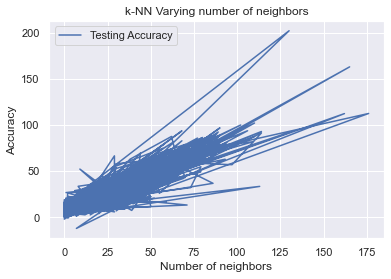

In [ ]:
plt.title('k-NN Varying number of neighbors')
plt.plot(y_test, y_pred, label='Testing Accuracy')
#plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

TypeError: '>' not supported between instances of 'int' and 'tuple'

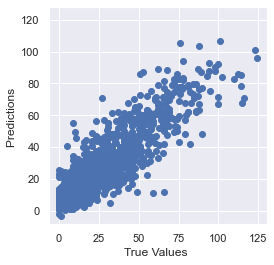

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values ')
plt.ylabel('Predictions ')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()])
plt.ylim([0, plt.ylim()])
_ = plt.plot([-100, 100], [-100, 100])

In [ ]:
from sklearn import metrics
from pandas import DataFrame,Series
from sklearn.metrics import explained_variance_score


lssvm = LSSVMRegression() 

lssvm.fit(X_train,y_train)
#Prediction using test set 
y_pred = lssvm.predict(X_test)
mae=metrics.mean_absolute_error(y_test, y_pred)
mse=metrics.mean_squared_error(y_test, y_pred)
# Printing the metrics
print('R2 square:',metrics.r2_score(y_test, y_pred))
print('MAE: ', mae)
print('MSE: ', mse)
print('EVS:', explained_variance_score(y_test, y_pred))

R2 square: 0.6658619116899106
MAE:  9.588573249834395
MSE:  174.57425262978626
EVS: 0.6658863993900147


In [ ]:
#model without PCA
from sklearn import metrics
from pandas import DataFrame,Series
from sklearn.metrics import explained_variance_score


lssvm = LSSVMRegression(kernel='rbf',gamma=1000.0,sigma=10.0) 

lssvm.fit(X_train1,y_train1)
#Prediction using test set 
y_pred = lssvm.predict(X_test1)
mae=metrics.mean_absolute_error(y_test1, y_pred)
mse=metrics.mean_squared_error(y_test1, y_pred)
# Printing the metrics
print('R2 square:',metrics.r2_score(y_test1, y_pred))
print('MAE: ', mae)
print('MSE: ', mse)
print('EVS:', explained_variance_score(y_test1, y_pred))

R2 square: 0.10007344174846267
MAE:  16.1056423343597
MSE:  478.8076122106696
EVS: 0.100161387726733


In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
#Prediction using test set 
y_pred = lin_reg.predict(X_test)
mae=metrics.mean_absolute_error(y_test, y_pred)
mse=metrics.mean_squared_error(y_test, y_pred)

# Printing the metrics
print('R2 square:',metrics.r2_score(y_test, y_pred))
print('MAE: ', mae)
print('MSE: ', mse)
print('EVS:', explained_variance_score(y_test, y_pred))

R2 square: 0.6521888787249772
MAE:  10.00984291648307
MSE:  171.26541172680098
EVS: 0.6523043173495994


In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train1,y_train1)
#Prediction using test set 
y_pred = lin_reg.predict(X_test1)
mae=metrics.mean_absolute_error(y_test1, y_pred)
mse=metrics.mean_squared_error(y_test1, y_pred)

# Printing the metrics
print('R2 square:',metrics.r2_score(y_test1, y_pred))
print('MAE: ', mae)
print('MSE: ', mse)
print('EVS:', explained_variance_score(y_test1, y_pred))

R2 square: 0.6767639004422467
MAE:  9.515439595991952
MSE:  168.94396873966633
EVS: 0.676860247564549


In [ ]:
dt_regressor = DecisionTreeRegressor(random_state = 0)
dt_regressor.fit(X_train,y_train)
#Predicting using test set 
y_pred = dt_regressor.predict(X_test)
mae=metrics.mean_absolute_error(y_test, y_pred)
mse=metrics.mean_squared_error(y_test, y_pred)
# Printing the metrics
print('Decision tree Regression Accuracy: ', dt_regressor.score(X_test,y_test))
print('R2 square:',metrics.r2_score(y_test, y_pred))
print('MAE: ', mae)
print('MSE: ', mse)
print('EVS:', explained_variance_score(y_test, y_pred))

Decision tree Regression Accuracy:  0.44859625979314677
R2 square: 0.44859625979314677
MAE:  11.93568281938326
MSE:  271.51629955947135
EVS: 0.45083995037944524


In [ ]:
dt_regressor = DecisionTreeRegressor(random_state = 0)
dt_regressor.fit(X_train1,y_train1)
#Predicting using test set 
y_pred = dt_regressor.predict(X_test1)
mae=metrics.mean_absolute_error(y_test1, y_pred)
mse=metrics.mean_squared_error(y_test1, y_pred)
# Printing the metrics
print('Decision tree Regression Accuracy: ', dt_regressor.score(X_test1,y_test1))
print('R2 square:',metrics.r2_score(y_test1, y_pred))
print('MAE: ', mae)
print('MSE: ', mse)
print('EVS:', explained_variance_score(y_test1, y_pred))

Decision tree Regression Accuracy:  0.5887152080470415
R2 square: 0.5887152080470415
MAE:  10.297797356828195
MSE:  214.9638766519824
EVS: 0.5891809673051644


In [ ]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train,y_train)
#Predicting the SalePrices using test set 
y_pred = rf_regressor.predict(X_test)
mae=metrics.mean_absolute_error(y_test, y_pred)
mse=metrics.mean_squared_error(y_test, y_pred)
# Printing the metrics
print('Random forest Regression Accuracy: ', rf_regressor.score(X_test,y_test))
print('R2 square:',metrics.r2_score(y_test, y_pred))
print('MAE: ', mae)
print('MSE: ', mse)


Random forest Regression Accuracy:  0.7002287209953622
R2 square: 0.7002287209953622
MAE:  8.882713656387667
MSE:  147.61014925110132


In [ ]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train1,y_train1)
#Predicting the SalePrices using test set 
y_pred = rf_regressor.predict(X_test1)
mae=metrics.mean_absolute_error(y_test1, y_pred)
mse=metrics.mean_squared_error(y_test1, y_pred)
# Printing the metrics
print('Random forest Regression Accuracy: ', rf_regressor.score(X_test1,y_test1))
print('R2 square:',metrics.r2_score(y_test1, y_pred))
print('MAE: ', mae)
print('MSE: ', mse)

Random forest Regression Accuracy:  0.8113802308726463
R2 square: 0.8113802308726463
MAE:  7.191647577092511
MSE:  98.58481903083701


In [ ]:
from sklearn.svm import SVR
regressor= SVR()
regressor.fit(X_train,y_train)
y_pred_svm=regressor.predict(X_test)
#y_pred_svm = cross_val_predict(regressor, x, y)
mae=metrics.mean_absolute_error(y_test, y_pred_svm)
mse=metrics.mean_squared_error(y_test, y_pred_svm)
EVS=explained_variance_score(y_test, y_pred_svm)
# Printing the metrics
print('Suppport Vector Regression Accuracy: ', regressor.score(X_test,y_test))
print('R2 square:',metrics.r2_score(y_test, y_pred_svm))
print()
print('MAE: ', mae)
print('MSE: ', mse)

Suppport Vector Regression Accuracy:  0.596891372510403
R2 square: 0.596891372510403

MAE:  10.113114122626767
MSE:  198.49441502774997


In [ ]:
from sklearn.svm import SVR
regressor= SVR()
regressor.fit(X_train1,y_train1)
y_pred_svm=regressor.predict(X_test1)
#y_pred_svm = cross_val_predict(regressor, x, y)
mae=metrics.mean_absolute_error(y_test1, y_pred_svm)
mse=metrics.mean_squared_error(y_test1, y_pred_svm)
EVS=explained_variance_score(y_test1, y_pred_svm)
# Printing the metrics
print('Suppport Vector Regression Accuracy: ', regressor.score(X_test1,y_test1))
print('R2 square:',metrics.r2_score(y_test1, y_pred_svm))
print()
print('MAE: ', mae)
print('MSE: ', mse)

Suppport Vector Regression Accuracy:  -0.05472575221956277
R2 square: -0.05472575221956277

MAE:  17.344664928893373
MSE:  551.2674938093211


In [ ]:
XGB= xg.XGBRegressor()
XGB.fit(X_train,y_train)
y_pred_svm=regressor.predict(X_test)
#y_pred_svm = cross_val_predict(regressor, x, y)
mae=metrics.mean_absolute_error(y_test, y_pred_svm)
mse=metrics.mean_squared_error(y_test, y_pred_svm)
EVS=explained_variance_score(y_test, y_pred_svm)
# Printing the metrics
print('XGBoost: ', XGB.score(X_test,y_test))
print('R2 square:',metrics.r2_score(y_test, y_pred_svm))
print()
print('MAE: ', mae)
print('MSE: ', mse)

ValueError: X.shape[1] = 10 should be equal to 15, the number of features at training time

In [ ]:
XGB= xg.XGBRegressor()
XGB.fit(X_train1,y_train1)
y_pred_svm=regressor.predict(X_test1)
#y_pred_svm = cross_val_predict(regressor, x, y)
mae=metrics.mean_absolute_error(y_test1, y_pred_svm)
mse=metrics.mean_squared_error(y_test1, y_pred_svm)
EVS=explained_variance_score(y_test1, y_pred_svm)
# Printing the metrics
print('XGBoost: ', XGB.score(X_test1,y_test1))
print('R2 square:',metrics.r2_score(y_test1, y_pred_svm))
print()
print('MAE: ', mae)
print('MSE: ', mse)


XGBoost:  0.8407480561617079
R2 square: -0.05472575221956277

MAE:  17.344664928893373
MSE:  551.2674938093211


CSA_LSSVM: 0.689214 (0.154222)


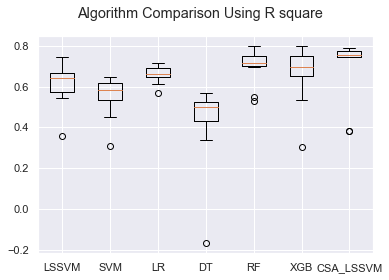

In [ ]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LSSVM',LSSVMRegression()))
models.append(('SVM', SVR()))
models.append(('LR', LinearRegression()))
models.append(('DT',DecisionTreeRegressor()))
models.append(('RF',RandomForestRegressor()))
models.append(('XGB',xg.XGBRegressor()))
models.append(('CSA_LSSVM',LSSVMRegression(sigma= 10, kernel='rbf', gamma= 1000.0)))
# evaluate each model in turn
results = []
names = []
scoring = 'r2'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X_train,y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(msg)
    
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison Using R square')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

CSA_LSSVM: 0.734356 (0.045506)


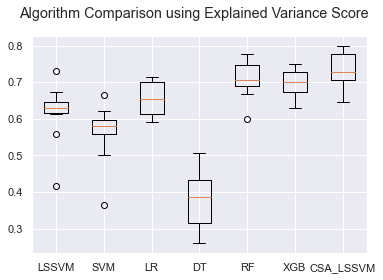

In [ ]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LSSVM',LSSVMRegression()))
models.append(('SVM', SVR()))
models.append(('LR', LinearRegression()))
models.append(('DT',DecisionTreeRegressor()))
models.append(('RF',RandomForestRegressor()))
models.append(('XGB',xg.XGBRegressor()))
models.append(('CSA_LSSVM',LSSVMRegression(sigma= 10, kernel='rbf', gamma= 1000.0)))
# evaluate each model in turn
results = []
names = []
scoring = 'explained_variance'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X_train,y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(msg)
    
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison using Explained Variance Score')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

CSA_LSSVM: -8.718664 (0.572953)


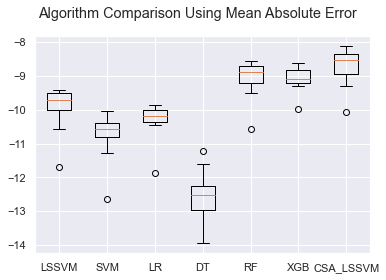

In [ ]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LSSVM',LSSVMRegression()))
models.append(('SVM', SVR()))
models.append(('LR', LinearRegression()))
models.append(('DT',DecisionTreeRegressor()))
models.append(('RF',RandomForestRegressor()))
models.append(('XGB',xg.XGBRegressor()))
models.append(('CSA_LSSVM',LSSVMRegression(sigma= 10, kernel='rbf', gamma= 1000.0)))
# evaluate each model in turn
results = []
names = []
scoring = 'neg_mean_absolute_error'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X_train,y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(msg)
    
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison Using Mean Absolute Error')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

CSA_LSSVM: -156.387373 (72.590319)


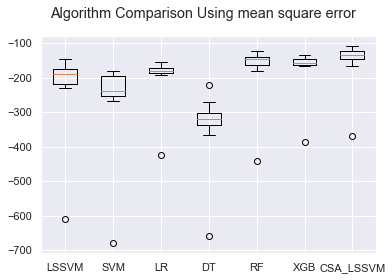

In [ ]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LSSVM',LSSVMRegression()))
models.append(('SVM', SVR()))
models.append(('LR', LinearRegression()))
models.append(('DT',DecisionTreeRegressor()))
models.append(('RF',RandomForestRegressor()))
models.append(('XGB',xg.XGBRegressor()))
models.append(('CSA_LSSVM',LSSVMRegression(sigma= 10, kernel='rbf', gamma= 1000.0)))
# evaluate each model in turn
results = []
names = []
scoring = 'neg_mean_squared_error'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X_train,y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(msg)
    
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison Using mean square error')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

CSA_LSSVM: -12.270499 (2.412929)


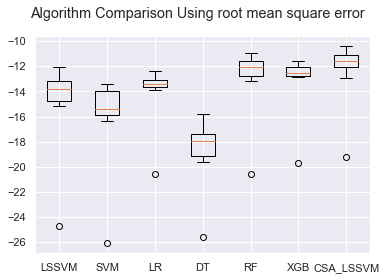

In [ ]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LSSVM',LSSVMRegression()))
models.append(('SVM', SVR()))
models.append(('LR', LinearRegression()))
models.append(('DT',DecisionTreeRegressor()))
models.append(('RF',RandomForestRegressor()))
models.append(('XGB',xg.XGBRegressor()))
models.append(('CSA_LSSVM',LSSVMRegression(sigma= 10, kernel='rbf', gamma= 1000.0)))
# evaluate each model in turn
results = []
names = []
scoring = 'neg_root_mean_squared_error'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X_train,y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(msg)
    
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison Using root mean square error')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

CSA_LSSVM: 0.077427 (0.023944)


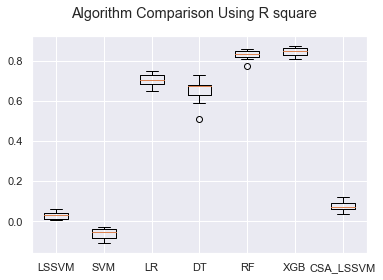

In [ ]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LSSVM',LSSVMRegression()))
models.append(('SVM', SVR()))
models.append(('LR', LinearRegression()))
models.append(('DT',DecisionTreeRegressor()))
models.append(('RF',RandomForestRegressor()))
models.append(('XGB',xg.XGBRegressor()))
models.append(('CSA_LSSVM',LSSVMRegression(sigma= 10, kernel='rbf', gamma= 1000.0)))
# evaluate each model in turn
results = []
names = []
scoring = 'r2'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X_train1,y_train1, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(msg)
    
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison Using R square')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

CSA_LSSVM: 0.081226 (0.022725)


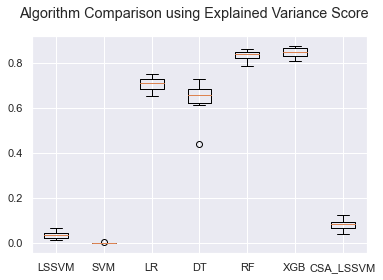

In [ ]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LSSVM',LSSVMRegression()))
models.append(('SVM', SVR()))
models.append(('LR', LinearRegression()))
models.append(('DT',DecisionTreeRegressor()))
models.append(('RF',RandomForestRegressor()))
models.append(('XGB',xg.XGBRegressor()))
models.append(('CSA_LSSVM',LSSVMRegression(sigma= 10, kernel='rbf', gamma= 1000.0)))
# evaluate each model in turn
results = []
names = []
scoring = 'explained_variance'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X_train1,y_train1, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(msg)
    
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison using Explained Variance Score')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

CSA_LSSVM: -16.516450 (1.287910)


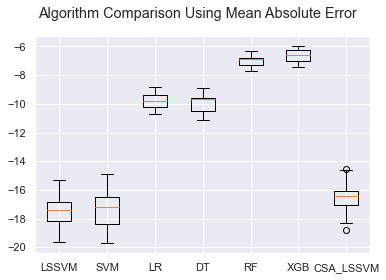

In [ ]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LSSVM',LSSVMRegression()))
models.append(('SVM', SVR()))
models.append(('LR', LinearRegression()))
models.append(('DT',DecisionTreeRegressor()))
models.append(('RF',RandomForestRegressor()))
models.append(('XGB',xg.XGBRegressor()))
models.append(('CSA_LSSVM',LSSVMRegression(sigma= 10, kernel='rbf', gamma= 1000.0)))
# evaluate each model in turn
results = []
names = []
scoring = 'neg_mean_absolute_error'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X_train1,y_train1, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(msg)
    
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison Using Mean Absolute Error')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

CSA_LSSVM: -515.832930 (77.986632)


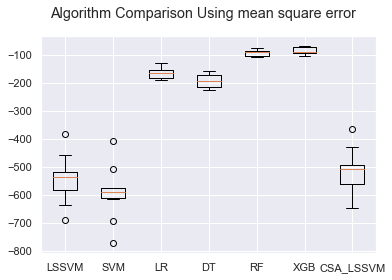

In [ ]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LSSVM',LSSVMRegression()))
models.append(('SVM', SVR()))
models.append(('LR', LinearRegression()))
models.append(('DT',DecisionTreeRegressor()))
models.append(('RF',RandomForestRegressor()))
models.append(('XGB',xg.XGBRegressor()))
models.append(('CSA_LSSVM',LSSVMRegression(sigma= 10, kernel='rbf', gamma= 1000.0)))
# evaluate each model in turn
results = []
names = []
scoring = 'neg_mean_squared_error'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model,  X_train1,y_train1, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(msg)
    
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison Using mean square error')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

CSA_LSSVM: -22.644787 (1.745437)


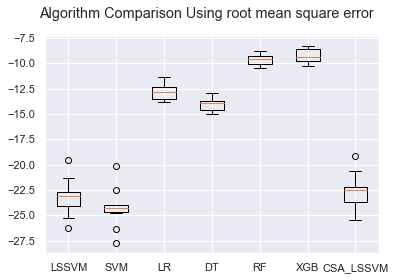

In [ ]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LSSVM',LSSVMRegression()))
models.append(('SVM', SVR()))
models.append(('LR', LinearRegression()))
models.append(('DT',DecisionTreeRegressor()))
models.append(('RF',RandomForestRegressor()))
models.append(('XGB',xg.XGBRegressor()))
models.append(('CSA_LSSVM',LSSVMRegression(sigma= 10, kernel='rbf', gamma= 1000.0)))
# evaluate each model in turn
results = []
names = []
scoring = 'neg_root_mean_squared_error'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model,  X_train1,y_train1, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(msg)
    
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison Using root mean square error')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

CSA LSSVM: 0.844336 (0.022022)


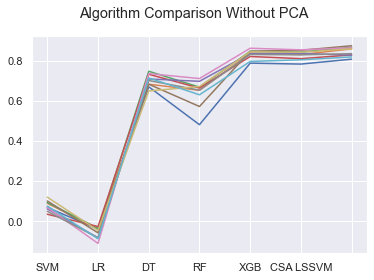

In [ ]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LSSVM',LSSVMRegression(kernel='rbf',gamma=1000.0,sigma=10.0)))
models.append(('SVM', SVR()))
models.append(('LR', LinearRegression()))
models.append(('DT',DecisionTreeRegressor()))
models.append(('RF',RandomForestRegressor()))
models.append(('XGB',RandomForestRegressor()))
models.append(('CSA LSSVM',xg.XGBRegressor()))
# evaluate each model in turn
results = []
names = []
scoring = 'r2'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X_train1,y_train1, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(msg)
    
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison Without PCA')
ax = fig.add_subplot(111)
plt.plot(results)
ax.set_xticklabels(names)
plt.show()

iteration = 1  best_fitness = 4304.10325728952
iteration = 2  best_fitness = 4302.6801427565715
iteration = 3  best_fitness = 4302.6801427565715
iteration = 4  best_fitness = 4302.428938753367
iteration = 5  best_fitness = 4231.5480412654
iteration = 6  best_fitness = 4231.212514979618
iteration = 7  best_fitness = 4229.781605259333
iteration = 8  best_fitness = 4229.781605259333
iteration = 9  best_fitness = 4227.448741910758
iteration = 10  best_fitness = 4219.847168363371
iteration = 11  best_fitness = 4219.847168363371
iteration = 12  best_fitness = 2488.7856750961028
iteration = 13  best_fitness = 2487.777275011198
iteration = 14  best_fitness = 2484.5589366533172
iteration = 15  best_fitness = 2220.7722697636636
iteration = 16  best_fitness = 2220.7722697636636
iteration = 17  best_fitness = 2220.7722697636636
iteration = 18  best_fitness = 2217.010278097496
iteration = 19  best_fitness = 2216.898137145364
iteration = 20  best_fitness = 2216.898137145364
iteration = 21  best_fitn

iteration = 169  best_fitness = 567.5898007212601
iteration = 170  best_fitness = 566.4073146365404
iteration = 171  best_fitness = 566.4073146365404
iteration = 172  best_fitness = 566.4073146365404
iteration = 173  best_fitness = 565.1873210364015
iteration = 174  best_fitness = 554.3400753825024
iteration = 175  best_fitness = 553.809621343589
iteration = 176  best_fitness = 552.8999223490607
iteration = 177  best_fitness = 548.8587586434809
iteration = 178  best_fitness = 548.8587586434809
iteration = 179  best_fitness = 548.8587586434809
iteration = 180  best_fitness = 548.1692887755097
iteration = 181  best_fitness = 546.784266727408
iteration = 182  best_fitness = 546.784266727408
iteration = 183  best_fitness = 533.6261863041613
iteration = 184  best_fitness = 532.9373397992397
iteration = 185  best_fitness = 531.8528900008249
iteration = 186  best_fitness = 531.8528900008249
iteration = 187  best_fitness = 531.779745783503
iteration = 188  best_fitness = 531.779745783503
itera

iteration = 335  best_fitness = 235.3971064890958
iteration = 336  best_fitness = 234.95563455770935
iteration = 337  best_fitness = 234.41850609331112
iteration = 338  best_fitness = 229.02735916906178
iteration = 339  best_fitness = 229.02735916906178
iteration = 340  best_fitness = 227.45864310993315
iteration = 341  best_fitness = 227.43022801754176
iteration = 342  best_fitness = 227.22755586967642
iteration = 343  best_fitness = 213.9614341974693
iteration = 344  best_fitness = 212.93338102150582
iteration = 345  best_fitness = 212.93338102150582
iteration = 346  best_fitness = 212.93338102150582
iteration = 347  best_fitness = 212.21403258833564
iteration = 348  best_fitness = 212.04579215798125
iteration = 349  best_fitness = 211.67528550249617
iteration = 350  best_fitness = 211.67528550249617
iteration = 351  best_fitness = 211.05888197895922
iteration = 352  best_fitness = 210.6659108057756
iteration = 353  best_fitness = 208.52272665631492
iteration = 354  best_fitness = 20

iteration = 500  best_fitness = 17.760530751592718
iteration = 501  best_fitness = 16.13999308897368
iteration = 502  best_fitness = 16.124475093845245
iteration = 503  best_fitness = 15.62206511668233
iteration = 504  best_fitness = 14.66194106688553
iteration = 505  best_fitness = 13.759675680502315
iteration = 506  best_fitness = 13.759675680502315
iteration = 507  best_fitness = 11.455386888693543
iteration = 508  best_fitness = 11.455386888693543
iteration = 509  best_fitness = 10.909514856217104
iteration = 510  best_fitness = 10.528665177267523
iteration = 511  best_fitness = 10.3568783125036
iteration = 512  best_fitness = 9.48544307086856
iteration = 513  best_fitness = 8.991252661711005
iteration = 514  best_fitness = 8.565268734769049
iteration = 515  best_fitness = 8.565268734769049
iteration = 516  best_fitness = 7.07441451519219
iteration = 517  best_fitness = 7.07441451519219
iteration = 518  best_fitness = 7.07441451519219
iteration = 519  best_fitness = 6.8952729461574

iteration = 661  best_fitness = 0.1754647616578704
iteration = 662  best_fitness = 0.1754647616578704
iteration = 663  best_fitness = 0.1754647616578704
iteration = 664  best_fitness = 0.1754647616578704
iteration = 665  best_fitness = 0.1754647616578704
iteration = 666  best_fitness = 0.1754647616578704
iteration = 667  best_fitness = 0.1754647616578704
iteration = 668  best_fitness = 0.1754647616578704
iteration = 669  best_fitness = 0.1754647616578704
iteration = 670  best_fitness = 0.1754647616578704
iteration = 671  best_fitness = 0.1754647616578704
iteration = 672  best_fitness = 0.1754647616578704
iteration = 673  best_fitness = 0.1754647616578704
iteration = 674  best_fitness = 0.1754647616578704
iteration = 675  best_fitness = 0.1754647616578704
iteration = 676  best_fitness = 0.1754647616578704
iteration = 677  best_fitness = 0.1754647616578704
iteration = 678  best_fitness = 0.1754647616578704
iteration = 679  best_fitness = 0.1754647616578704
iteration = 680  best_fitness =

iteration = 821  best_fitness = 0.07687166320163509
iteration = 822  best_fitness = 0.07687166320163509
iteration = 823  best_fitness = 0.07687166320163509
iteration = 824  best_fitness = 0.07687166320163509
iteration = 825  best_fitness = 0.07687166320163509
iteration = 826  best_fitness = 0.07687166320163509
iteration = 827  best_fitness = 0.07687166320163509
iteration = 828  best_fitness = 0.07687166320163509
iteration = 829  best_fitness = 0.07687166320163509
iteration = 830  best_fitness = 0.07687166320163509
iteration = 831  best_fitness = 0.07687166320163509
iteration = 832  best_fitness = 0.07687166320163509
iteration = 833  best_fitness = 0.07687166320163509
iteration = 834  best_fitness = 0.07687166320163509
iteration = 835  best_fitness = 0.07687166320163509
iteration = 836  best_fitness = 0.07687166320163509
iteration = 837  best_fitness = 0.07687166320163509
iteration = 838  best_fitness = 0.07687166320163509
iteration = 839  best_fitness = 0.07687166320163509
iteration = 

iteration = 979  best_fitness = 0.07687166320163509
iteration = 980  best_fitness = 0.07687166320163509
iteration = 981  best_fitness = 0.07687166320163509
iteration = 982  best_fitness = 0.07687166320163509
iteration = 983  best_fitness = 0.07687166320163509
iteration = 984  best_fitness = 0.07687166320163509
iteration = 985  best_fitness = 0.07687166320163509
iteration = 986  best_fitness = 0.07687166320163509
iteration = 987  best_fitness = 0.07687166320163509
iteration = 988  best_fitness = 0.07687166320163509
iteration = 989  best_fitness = 0.07687166320163509
iteration = 990  best_fitness = 0.07687166320163509
iteration = 991  best_fitness = 0.07687166320163509
iteration = 992  best_fitness = 0.07687166320163509
iteration = 993  best_fitness = 0.07687166320163509
iteration = 994  best_fitness = 0.07687166320163509
iteration = 995  best_fitness = 0.07687166320163509
iteration = 996  best_fitness = 0.07687166320163509
iteration = 997  best_fitness = 0.07687166320163509
iteration = 

PermissionError: [Errno 13] Permission denied: 'predicted_data.csv'

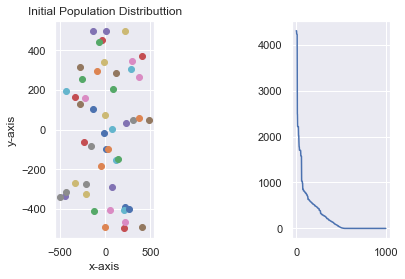

In [ ]:
##CS
"""
INTRODUCTION:

THIS IS A MODEL WHICH IS USING AS A REGRESSION MODEL.
THIS MODEL USES TRAIN DATA SET OF ADDITION, IN WHICH IT ADDS THREE VALUES AND GIVE OUTPUTS.
WE ARE USING A RATIO OF 7:3 FOR TRAIN DATASET AND TEST DATASET RESPECTIVELY.
AT THE END, WHEN PROGRAM RAN SUCCESSFULLY, THE OUTPUT YOU WILL GET WILL BE BASED ON THE GIVEN DATA SET,YOU WILL GET YOUR:-
I)   DESIRED WEIGHTS
II)  ROOT MEAN SQUARE ERROR (RMSE) VALUE
III) ACCURACY (between 0 to 1) 
IV)  THREE GRAPHS SHOWING INITIAL POPULATION, FINAL POPULATION AND FITNESS(RMSE) CURVE.
"""


"""  
IN THIS CODE MOST OF THE THINGS WILL BE SAME AS CUCKOO SEARCH,
JUST DIFFERENCES ARE THE FOLLOWING:
1. NO. OF WEIGHTS (WHICH IS EQUAL TO NO. OF INPUTS IN AN ANN) WILL BE EQUAL TO NO. OF DIMENSIONS.
2. IN Individual CLASS FOR EACH CUCKOO FITNESS WILL BE CALULATED BY rmse (ROOT
   MEAN SQUARE ERROR) FUNC OF ANN, INSTEAD OF OBJECTIVE FUNC.
3. ACCURACY FUNCTION IS USED TO CALCULATE ACCURACY.
"""

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import csv
import random
from math import sqrt
import sklearn.metrics as metrics

# INITIALIZATION
population_size = 50
max_generation = 1000
_lambda = 1.5
dimension = 3
max_domain = 500
min_domain = -500
step_size_cons = 0.01
Pa = 0.25
x = []
y = []

# CALCULATING ACCURACY USING r2 SCORE (since this model is currently getting used as a regression model)
def accuracy(array, data, labels, data_size):
    y_predicted = []
    for i in range(data_size):
        y_predicted.append(np.dot(data[i], array))
    x_actual = labels
    acc = metrics.r2_score(x_actual, y_predicted)
    return acc

# OBJECTIVE FUNCTION
def rmse(array, data, labels, data_size):  # CONVERTING THIS FUNCTION INTO rmse FUNC OF ANN
    y_predicted = []
    for i in range(data_size):
        y_predicted.append(np.dot(data[i], array))
    x_actual = labels
    fitness = sqrt(metrics.mean_squared_error(x_actual, y_predicted))
    return fitness

# LEVY FLIGHT
def levy_flight(Lambda):
    sigma1 = np.power((math.gamma(1 + Lambda) * np.sin((np.pi * Lambda) / 2)) \
                      / math.gamma((1 + Lambda) / 2) * np.power(2, (Lambda - 1) / 2), 1 / Lambda)
    sigma2 = 1
    u = np.random.normal(0, sigma1, size=dimension)
    v = np.random.normal(0, sigma2, size=dimension)
    step = u / np.power(np.fabs(v), 1 / Lambda)

    return step

class Individual:
    def __init__(self, data, labels, data_size):
        self.__position = np.random.rand(dimension) * (max_domain - min_domain) + min_domain
        self.__fitness = rmse(self.__position, data, labels, data_size)

    def get_position(self):
        return self.__position

    def get_fitness(self):
        return self.__fitness

    def set_position(self, position):
        self.__position = position

    def set_fitness(self, fitness):
        self.__fitness = fitness

    def abandon(self, data, labels, data_size):
        # abandon some variables
        for i in range(dimension):
            p = np.random.rand()
            if p < Pa:
                self.__position[i] = np.random.rand() * (max_domain - min_domain) + min_domain
                self.__fitness = rmse(self.__position, data, labels, data_size)

        
        
        
        
def fit(self,X:np.ndarray,y:np.ndarray):
        
        #print("IN FIT==> GAMMA=",self.gamma,"  SIGMA=",self.sigma)
        
        if isinstance(X,pd.DataFrame) or isinstance(X,pd.Series):
            Xloc=X.to_numpy()
        else:
            Xloc=X
        
        if isinstance(y,pd.DataFrame) or isinstance(y,pd.Series):
            yloc=y.to_numpy()
        else:
            yloc=y
        
        #check the dimensionality of the input
        if (Xloc.ndim==2) and (yloc.ndim==1):
            self.x = Xloc
            self.y = yloc
            self.__OptimizeParams()
        else:
            message="The fit procedure requires a 2D numpy array of features and 1D array of targets"
            raise Exception(message)
            
def main():

    """
    #WRITING RANDOM TRAIN DATA
    train_data_size = 100
    row = [[random.randint(0,100), random.randint(0,100), random.randint(0, 100), 0] for i in range(train_data_size+1)]
    row[0] = ['INPUT1', 'INPUT2', 'INPUT3', 'OUTPUT']
    for i in range(1, train_data_size+1):
        row[i][3] = row[i][0]+row[i][1]+row[i][2]

    with open('train_data.csv', 'w') as csvFile:
        writer = csv.writer(csvFile)
        for i in range(train_data_size+1):
            writer.writerow(row[i])

    csvFile.close()
    """

    # READING TRAIN DATA
    t_data = pd.read_csv('train_data.csv')
    phase1 = t_data.drop(['OUTPUT'], axis=1) # DROPING OUTPUT COLUMN FROM DATA SET
    phase2 = phase1.values                   # CONVERTING THE WHOLE DATA INTO NUMPY ARRAY IN ROW MAJOR
    train_data = phase2.tolist()             # CONVERTING THE 2D NUMPY ARRAY INTO LIST
    labels = t_data['OUTPUT'].tolist()       # EXTRACTING LABELS FROM DATA SET
    train_data_size = len(t_data)
    # print(train_data)

    # RANDOMLY CREATING HOSTS
    cs_list = []
    for i in range(population_size):
        cs_list.append(Individual(train_data, labels, train_data_size))


    # SORT TO GET THE BEST FITNESS
    cs_list = sorted(cs_list, key=lambda ID: ID.get_fitness())

    best_fitness = cs_list[0].get_fitness()
    best_position = cs_list[0].get_position()

    fig = plt.figure()

    # INITIAL POPULATION DISTRIBUTION
    ax1 = fig.add_subplot(131)
    for i in range(population_size):
        ax1.scatter([cs_list[i].get_position()[0]], [cs_list[i].get_position()[1]])
    ax1.set_title('Initial Population Distributtion')
    ax1.set_xlabel('x-axis')
    ax1.set_ylabel('y-axis')

    ax3 = fig.add_subplot(133)

    t = 1
    while t < max_generation:

        # GENERATING NEW SOLUTIONS
        for i in range(population_size):

            # CHOOSING A RANDOM CUCKOO (say i)
            i = np.random.randint(low=0, high=population_size)

            # SETTING ITS POSITION USING LEVY FLIGHT
            position = (cs_list[i].get_position())+(step_size_cons*levy_flight(_lambda))

            # Simple Boundary Rule
            for i in range(dimension):
                if position[i] > max_domain:
                    position[i] = max_domain
                if position[i] < min_domain:
                    position[i] = min_domain

            cs_list[i].set_position(position)
            cs_list[i].set_fitness(rmse(cs_list[i].get_position(), train_data, labels, train_data_size))

            # CHOOSING A RANDOM HOST (say j)
            j = np.random.randint(0, population_size)
            while j == i:  # random id[say j] ≠ i
                j = np.random.randint(0, population_size)

            # RELAXATION
            if cs_list[j].get_fitness() > cs_list[i].get_fitness():
                cs_list[j].set_position(cs_list[i].get_position())
                cs_list[j].set_fitness(cs_list[i].get_fitness())

        # SORT (to Keep Best)
        cs_list = sorted(cs_list, key=lambda ID: ID.get_fitness())

        # ABANDON SOLUTION (exclude the best)
        for a in range(1, population_size):
            r = np.random.rand()
            if (r < Pa):
                cs_list[a].abandon(train_data, labels, train_data_size)

        # RANKING THE CS LIST
        cs_list = sorted(cs_list, key=lambda ID: ID.get_fitness())

        # FIND THE CURRENT BEST
        if cs_list[0].get_fitness() < best_fitness:
            best_fitness = cs_list[0].get_fitness()
            best_position = cs_list[0].get_position()

        # PRINTING SOLUTION IN EACH ITERATION
        print("iteration =", t, " best_fitness =", best_fitness)

        # FITNESS ARRAY
        x.append(t)
        y.append(best_fitness)

        t += 1

    # FITNESS PLOTTING
    ax3.plot(x, y)

    # OPTIMIZED WEIGHTS
    print("\nOptimized weights are ", *best_position)

    """
    #WRITING RANDOM TEST DATA
    test_data_size = 30
    row = [[random.randint(0, 100), random.randint(0, 100), random.randint(0, 100), 0] for i in range(test_data_size+1)]
    row[0] = ['INPUT1', 'INPUT2', 'INPUT3', 'OUTPUT']
    for i in range(1, test_data_size+1):
        row[i][3] = row[i][0]+row[i][1]+row[i][2]

    with open('test_data.csv', 'w') as csvFile:
        writer = csv.writer(csvFile)
        for i in range(test_data_size+1):
            writer.writerow(row[i])

    csvFile.close()
    """

    # READING TEST DATA
    test_data = pd.read_csv('test_data.csv')
    td = test_data.drop(['OUTPUT'], axis=1).values.tolist()
    test_labels = test_data['OUTPUT'].tolist()
    test_data_size = len(test_data)
    # print(test_data['INPUT1'][0])


    print("RMSE of of final ANN is ", rmse(best_position, td, test_labels, test_data_size))
    print("Accuracy of final ANN is ", accuracy(best_position, td, test_labels, test_data_size))

    # WRITE PREDICTED OBSERVATION DATA
    row = [['INPUT1', 'INPUT2', 'INPUT3', 'ACTUAL OUTPUT', 'PREDICTED OUTPUT']]

    for i in range(test_data_size):
        predicted_output = np.dot(td[i], best_position)
        row.append([td[i][0], td[i][1], td[i][2], test_data['OUTPUT'][i], predicted_output])

    with open('predicted_data.csv', 'w') as csvFile:
        writer = csv.writer(csvFile)
        for i in range(test_data_size+1):
            writer.writerow(row[i])

    csvFile.close()

    # GRAPH FOR FITNESS
    ax3.set_title('Fitness Curve')
    ax3.set_xlabel('x-axis')
    ax3.set_ylabel('y-axis')

    # FINAL POPULATION DISTRIBUTION
    ax2 = fig.add_subplot(132)
    for i in range(population_size):
        ax2.scatter([cs_list[i].get_position()[0]], [cs_list[i].get_position()[1]])
    ax2.set_title('Final Population Distributtion after '+str(t)+' iterations')
    ax2.set_xlabel('x-axis')
    ax2.set_ylabel('y-axis')

    # SHOWING GRAPH
    plt.show()


if __name__ == "__main__":
    main()

In [ ]:
from scipy.integrate import odeint
sigma = 10
rho = 28
beta = 8.0/3
theta = 3 * np.pi / 4
def lorenz(xyz, t):
    x, y, z = xyz
    x_dot = sigma * (y - x)
    y_dot = x * rho - x * z - y
    z_dot = x * y - beta* z
    return [x_dot, y_dot, z_dot]
initial = (-10, -7, 35)
t = np.arange(0, 100, 0.006)
solution = odeint(lorenz, initial, t)
x = solution[:, 0]
y = solution[:, 1]
z = solution[:, 2]
xprime = np.cos(theta) * x - np.sin(theta) * y
colors = ["#C6DBEF", "#9ECAE1", "#6BAED6", "#4292C6", "#2171B5", "#08519C", "#08306B",]
fig = figure(title="Lorenz attractor example", background_fill_color="#fafafa")
fig.multi_line(np.array_split(xprime, 7), np.array_split(z, 7),
             line_color=colors, line_alpha=0.8, line_width=1.5)
show(fig)

NameError: name 'figure' is not defined

In [ ]:
# Having an equal amount of bill shared among different transformers
# since each row of the data represent each customer assigned to different transformers
# a function, that groups the row on the transformer can be counted, take the sum of customers 
# assigned to each transformer divided by the total transformers avilable.
# for instance if we have 5 transformers but 600 bills is shared among customers, to have 
# even/equal distribution among the 5 transformers, it then mean 600/5= 120 customers on each transformer
# however,knowing the exact transformer the customers will belong to may need machine learning 
# model like clustering customer closer to a certain region automatically.


#Example

import pandas as pd
data = {'Transformer':  ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z'],
        'CSP': ['O','P','Q','R','S','T','Y','D','U','V','W','X','E','F','G','H','Z','A','B','C','I','J','K','L','M','N','O','P','Q','R','S','T','Y','D','U','V','W','X','E','F','G','H','Z','A','B','C','I','J','K','L','M','N','O','P','Q','R','S','T','Y','D','U','V','W','X','E','F','G','H','Z','A','B','C','I','J','K','L','M','N','O','P','Q','R','S','T','Y','D','U','V','W','X','E','F','G','H','Z','A','B','C','I','J','K','L','M','N'],
        }

df=pd.DataFrame(data,columns=['Transformer', 'CSP'])

In [ ]:
df.head()

,Transformer,CSP
0,a,O
1,b,P
2,c,Q
3,d,R
4,e,S


In [ ]:
def Even_bill():
    trans=df.groupby('Transformer').count().sum()
    county=df.groupby('Transformer').count()
    distribute= trans.sum()/county
    print(distribute)



In [ ]:
Even_bill()

              CSP
Transformer      
a            26.0
b            26.0
c            26.0
d            26.0
e            26.0
f            26.0
g            26.0
h            26.0
i            26.0
j            26.0
k            26.0
l            26.0
m            26.0
n            26.0
o            26.0
p            26.0
q            26.0
r            26.0
s            26.0
t            26.0
u            26.0
v            26.0
w            26.0
x            26.0
y            26.0
z            26.0


In [ ]:
trans=df.groupby('Transformer').count().sum()

In [ ]:
county=df.groupby('Transformer').count()

In [ ]:
county.head()

,CSP
Transformer,
a,4
b,4
c,4
d,4
e,4


In [ ]:
trans.head(30)

CSP    104
dtype: int64

In [ ]:
distribute= trans.sum()/county

In [ ]:
distribute

,CSP
Transformer,
a,26.0
b,26.0
c,26.0
d,26.0
e,26.0
f,26.0
g,26.0
h,26.0
i,26.0


In [ ]:
hate words =['fuck', 'kill','dislike','rant','aboki','yarbawa','Nigga','black']

speech =  